Adapted from https://github.com/pumpikano/tf-dann

In [1]:
# Import all the packages needed

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from flip_gradient import flip_gradient
from keras.layers import Input, concatenate, Conv3D, MaxPooling3D, Conv3DTranspose, Flatten, Dense

import os
from tensorflow import set_random_seed
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
set_random_seed(3)
np.random.seed(3)

%matplotlib inline

import pickle as pkl
from sklearn.metrics import f1_score, accuracy_score
from keras import backend as K

from utils import *

import random
import statistics

/export/share/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set the network hyperparameters

params = {'model': 'Unet_6',
          'training_mode': 'dann', # source, target or dann
          'mu0': 1e-2,
          'alpha': 10,
          'beta': 1,
          'p1': 0.2,
          'p2': 0.7,
          'l_max': 3,
          #'lambda': 0,
         'num_steps': int(1e4),
         'batch_size': 4,
         'n_feat_maps': 16,
         'psi': 0.01,
         'fc': 'cnn'}
dest_dir = 'results'
save_session = False

In [3]:
# Implement the network

model_X = tf.placeholder(tf.uint8, [None, 40, 40, 32, 1])
model_y = tf.placeholder(tf.float32, [None, 40, 40, 32])
model_domain = tf.placeholder(tf.float32, [None, 2])
model_l = tf.placeholder(tf.float32, [])
model_train = tf.placeholder(tf.bool, [])
        
pixel_mean = 86.62597169503347
pixel_std = 15.921692390390666
X_input = (tf.cast(model_X, tf.float32) - pixel_mean) / pixel_std
        
# Downsampling
        
inputs = X_input
conv1 = Conv3D(params['n_feat_maps'], (3, 3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv3D(params['n_feat_maps'], (3, 3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

conv2 = Conv3D(params['n_feat_maps'] * 2, (3, 3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv3D(params['n_feat_maps'] * 2, (3, 3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

conv3 = Conv3D(params['n_feat_maps'] * 4, (3, 3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv3D(params['n_feat_maps'] * 4, (3, 3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
        
# Bottleneck and feature extractor

conv4 = Conv3D(params['n_feat_maps'] * 8, (3, 3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv3D(params['n_feat_maps'] * 8, (3, 3, 3), activation='relu', padding='same')(conv4)
              
# Upsampling
        
copy3 = conv3
up5 = concatenate(
            [Conv3DTranspose(params['n_feat_maps'] * 4, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv4), copy3],
            axis=4)
conv5 = Conv3D(params['n_feat_maps'] * 4, (3, 3, 3), activation='relu', padding='same')(up5)
conv5 = Conv3D(params['n_feat_maps'] * 4, (3, 3, 3), activation='relu', padding='same')(conv5)
        
copy2 = conv2
up6 = concatenate(
            [Conv3DTranspose(params['n_feat_maps'] * 2, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv5), copy2],
            axis=4)
conv6 = Conv3D(params['n_feat_maps'] * 2, (3, 3, 3), activation='relu', padding='same')(up6)
conv6 = Conv3D(params['n_feat_maps'] * 2, (3, 3, 3), activation='relu', padding='same')(conv6)
model_feature = conv6
conv6_all = lambda: conv6
conv6_source = lambda: tf.slice(conv6, [0,0,0,0, 0], [params['batch_size']//2, 20,20, 16, params['n_feat_maps'] * 2])
conv6 = tf.cond(model_train, conv6_source, conv6_all)

copy1_all = lambda: conv1
copy1_source = lambda: tf.slice(conv1, [0,0,0,0, 0], [params['batch_size']//2, 40, 40, 32, params['n_feat_maps'] * 1])
copy1 = tf.cond(model_train, copy1_source, copy1_all)
up7 = concatenate(
            [Conv3DTranspose(params['n_feat_maps'] * 1, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6), copy1],
            axis=4)
conv7 = Conv3D(params['n_feat_maps'] * 1, (3, 3, 3), activation='relu', padding='same')(up7)
conv7 = Conv3D(params['n_feat_maps'] * 1, (3, 3, 3), activation='relu', padding='same')(conv7)

conv8 = Conv3D(1, (1,1,1))(conv7)
        
# === Label predictor ===
        
all_labels = lambda: model_y
source_labels = lambda: tf.slice(model_y, [0,0,0, 0], [params['batch_size']//2, 40, 40, 32])
model_classify_labels = tf.cond(model_train, source_labels, all_labels)
            
logits = tf.squeeze(conv8)
model_pred = tf.nn.sigmoid(logits)
        
model_pred_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=model_classify_labels)

# === Domain classifier ===
        
feat = flip_gradient(model_feature, model_l)
            
convA = Conv3D(100, (3,3,3), activation='relu')(feat)
convA = Conv3D(100,(3,3,3), activation='relu')(convA)
poolA = MaxPooling3D((2,2,2))(convA)
convB = Conv3D(100,(3,3,3), activation='relu')(poolA)
convB = Conv3D(100,(3,3,3), activation='relu')(convB)
fl = Flatten()(convB)
dense = Dense(100, activation='relu')(fl)
d_logits = Dense(2)(dense)
            
model_domain_pred = tf.nn.softmax(d_logits)
model_domain_loss = tf.nn.softmax_cross_entropy_with_logits(logits=d_logits, labels=model_domain)

In [4]:
# Set the losses, optimizers and evaluation

graph = tf.get_default_graph()
with graph.as_default():
    learning_rate = tf.placeholder(tf.float32, [])
    
    pred_loss = tf.reduce_mean(model_pred_loss)
    domain_loss = tf.reduce_mean(model_domain_loss)
    total_loss = pred_loss + params['psi']*domain_loss

    regular_train_op = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(pred_loss)
    dann_train_op = tf.train.MomentumOptimizer(learning_rate, 0.9).minimize(total_loss)
    
    # Evaluation
    correct_label_pred = tf.equal(K.flatten(model_classify_labels), tf.cast(tf.greater(K.flatten(model_pred), 0.5), tf.float32))
    label_acc = tf.reduce_mean(tf.cast(correct_label_pred, tf.float32))
    correct_domain_pred = tf.equal(tf.argmax(model_domain, 1), tf.argmax(model_domain_pred, 1))
    domain_acc = tf.reduce_mean(tf.cast(correct_domain_pred, tf.float32))

In [5]:
# Training and Test

saver = tf.train.Saver()
verbose = 1
training_mode = params['training_mode']
with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()

    # Prepare the datasets
    
    filenames = ['ct_train_'+str(ind) for ind in range(30)]
    gen_source_only_batch_train = batch_generator_files(filenames, params['batch_size'], shuffle=True)
    gen_source_batch_train = batch_generator_files(filenames, params['batch_size'] // 2, shuffle=True)

    filenames = ['ct_test_'+str(ind) for ind in range(30)]
    gen_source_only_batch_test = batch_generator_files(filenames, params['batch_size'], shuffle=False)
    gen_source_batch_test = batch_generator_files(filenames, params['batch_size'] // 2, shuffle=False)

    filenames = ['cbct_train_'+str(ind) for ind in range(30)]
    gen_target_only_batch_train = batch_generator_files(filenames, params['batch_size'], shuffle=True)
    gen_target_batch_train = batch_generator_files(filenames, params['batch_size'] // 2, shuffle=True)

    filenames = ['cbct_test_'+str(ind) for ind in range(30)]
    gen_target_only_batch_test = batch_generator_files(filenames, params['batch_size'], shuffle=False)
    gen_target_batch_test = batch_generator_files(filenames, params['batch_size'] // 2, shuffle=False)

    domain_labels = np.vstack([np.tile([1., 0.], [params['batch_size'] // 2, 1]),
                               np.tile([0., 1.], [params['batch_size'] // 2, 1])])

    total_dice_dann = []
    total_dice_source = []
    total_dice_target = []
    
    total_original_images_dann = []
    total_original_masks_dann = []
    total_pred_masks_dann = []
    
    total_original_images_source = []
    total_original_masks_source = []
    total_pred_masks_source = []
    
    total_original_images_target = []
    total_original_masks_target = []
    total_pred_masks_target = []
    
    mydict = {'loss': np.zeros(params['num_steps']),
           'd_acc': np.zeros(params['num_steps']),
           'p_acc': np.zeros(params['num_steps']),
           'l': np.zeros(params['num_steps']),
           'dloss': np.zeros(params['num_steps']),
           'ploss': np.zeros(params['num_steps']),
             'd_acc_test': np.zeros(int(params['num_steps']/100)),
              'd_acc_train': np.zeros(int(params['num_steps']/100)),
              'tloss_train': np.zeros(int(params['num_steps']/100)),
              'dice_ct_train': np.zeros(int(params['num_steps']/100)),
             'dice_ct_test': np.zeros(int(params['num_steps']/100)),
             'dice_cbct_train': np.zeros(int(params['num_steps']/100)),
             'dice_cbct_test': np.zeros(int(params['num_steps']/100)),
             'loss_smooth': np.zeros(int(params['num_steps']/100)),
             'pred_loss_train': np.zeros(int(params['num_steps']/100)),
             'pred_loss_test': np.zeros(int(params['num_steps']/100)),
             'domain_loss_train': np.zeros(int(params['num_steps']/100)),
             'domain_loss_test': np.zeros(int(params['num_steps']/100))}

    
    # Training loop, i is the index for every step.
    
    for i in range(params['num_steps']):

        # Adaptation param and learning rate schedule as described in the paper
        
        p = float(i) / params['num_steps']
        if 'lambda' in params.keys():
            l = params['lambda']
        elif 'p1' in params.keys() and 'p2' in params.keys() and 'l_max' in params.keys():
            l = params['l_max']*np.clip((p-params['p1'])/(params['p2']-params['p1']), 0., 1.)
        else:
            l = 2. / (1. + np.exp(-params['gamma'] * p)) - 1
        lr = params['mu0'] / (1. + params['alpha'] * p)**params['beta']

        
        # First experiment training step:: lower bound
        if training_mode == 'source':
            X, y = next(gen_source_only_batch_train)
            _, batch_loss = sess.run([regular_train_op, pred_loss],
                                 feed_dict={model_X: X, model_y: y, model_train: False,
                                            model_l: l, learning_rate: lr})
            
        # Second experiment training step: upper bound
        elif training_mode == 'target':
            X, y = next(gen_target_only_batch_train)
            _, batch_loss = sess.run([regular_train_op, pred_loss],
                                 feed_dict={model_X: X, model_y: y, model_train: False,
                                            model_l: l, learning_rate: lr})
            
        # Third and fourth experiments training step: UDA            
        elif training_mode == 'dann':
            X0, y0 = next(gen_source_batch_train)
            X1, y1 = next(gen_target_batch_train)
            X = np.vstack([X0, X1])
            y = np.vstack([y0, y1])

            _, batch_loss, dloss, ploss, d_acc, p_acc = sess.run(
                [dann_train_op, total_loss, domain_loss, pred_loss, domain_acc, label_acc],
                feed_dict={model_X: X, model_y: y, model_domain: domain_labels,
                           model_train: True, model_l: l, learning_rate: lr})

        if verbose and i % 100 == 0:
            mydict['l'][i//100] = l
            n_batches = 30//params['batch_size']
            pred_loss_train = 0
            domain_loss_train = 0
            pred_loss_test = 0
            domain_loss_test = 0
            d_acc_train = 0
            loss_test = 0
            d_acc_test = 0
            loss_smooth = 0

            
            if training_mode=='dann':
                
                # loss_train and d_acc_train
                for _ in range(2*n_batches):
                    X0, y0 = next(gen_source_batch_train)
                    X1, y1 = next(gen_target_batch_train)
                    X = np.vstack([X0, X1])
                    y = np.vstack([y0, y1])
                    pred_loss_batch, domain_loss_batch, d_acc_batch = sess.run([pred_loss, domain_loss, domain_acc],
                            feed_dict={model_X: X, model_y: y, model_domain: domain_labels,
                           model_train: True})
                    pred_loss_train += pred_loss_batch
                    domain_loss_train += domain_loss_batch
                    d_acc_train += d_acc_batch
                mydict['pred_loss_train'][i//100] = pred_loss_train/(2*n_batches)
                mydict['domain_loss_train'][i//100] = domain_loss_train/(2*n_batches)
                mydict['d_acc_train'][i//100] = d_acc_train/(2*n_batches)

                # loss_test and d_acc_test
                for _ in range(2*n_batches):
                    X0, y0 = next(gen_source_batch_test)
                    X1, y1 = next(gen_target_batch_test)
                    X = np.vstack([X0, X1])
                    y = np.vstack([y0, y1])
                    pred_loss_batch, domain_loss_batch, d_acc_batch = sess.run([pred_loss, domain_loss, domain_acc],
                            feed_dict={model_X: X, model_y: y, model_domain: domain_labels,
                           model_train: True})
                    pred_loss_test += pred_loss_batch
                    domain_loss_test += domain_loss_batch
                    d_acc_test += d_acc_batch
                mydict['pred_loss_test'][i//100] = pred_loss_test/(2*n_batches)
                mydict['domain_loss_test'][i//100] = domain_loss_test/(2*n_batches)
                mydict['d_acc_test'][i//100] = d_acc_test/(2*n_batches)

            # dice_ct_train and loss_smooth
            dice_ct_train = 0
            for _ in range(n_batches):
                X_batch, y_batch = next(gen_source_only_batch_train)
                pred_batch = sess.run(model_pred, feed_dict={model_X: X_batch, model_train: False})
                if training_mode =='source':
                    loss_smooth += sess.run(pred_loss,feed_dict={model_X: X_batch, model_y: y_batch, model_train: False})
                pred_batch_thr = (pred_batch>0.5)
                for ind in range(params['batch_size']):
                        dice_ct_train += f1_score(y_batch[ind,:,:].flatten(), pred_batch_thr[ind,:,:].flatten())
            dice_ct_train = dice_ct_train/30
            mydict['dice_ct_train'][i//100] = dice_ct_train

            # dice_ct_test
            dice_ct_test = 0
            for _ in range(n_batches):
                X_batch, y_batch = next(gen_source_only_batch_test)
                #print('X_batch.shape', X_batch.shape)
                pred_batch = sess.run(model_pred, feed_dict={model_X: X_batch, model_train: False})
                pred_batch_thr = (pred_batch>0.5)
                #print('pred_batch_thr.shape', pred_batch_thr.shape)
                for ind in range(params['batch_size']):
                    dice_ct_test += f1_score(y_batch[ind,:,:].flatten(), pred_batch_thr[ind,:,:].flatten())
            dice_ct_test = dice_ct_test/30
            mydict['dice_ct_test'][i//100] = dice_ct_test

            # dice_cbct_train and loss_smooth
            dice_cbct_train = 0
            for b in range(n_batches):
                X_batch, y_batch = next(gen_target_only_batch_train)
                pred_batch = sess.run(model_pred, feed_dict={model_X: X_batch, model_train: False})
                if training_mode =='target':
                    loss_smooth += sess.run(pred_loss,feed_dict={model_X: X_batch, model_y: y_batch, model_train: False})
                pred_batch_thr = (pred_batch>0.5)
                for ind in range(params['batch_size']):
                    dice_cbct_train += f1_score(y_batch[ind,:,:].flatten(), pred_batch_thr[ind,:,:].flatten())
                    
            dice_cbct_train = dice_cbct_train/30
            mydict['dice_cbct_train'][i//100] = dice_cbct_train

            # dice_cbct_test
            dice_cbct_test = 0
            for _ in range(n_batches):
                X_batch, y_batch = next(gen_target_only_batch_test)
                pred_batch = sess.run(model_pred, feed_dict={model_X: X_batch, model_train: False})
                pred_batch_thr = (pred_batch>0.5)
                for ind in range(params['batch_size']):
                    dice_cbct_test += f1_score(y_batch[ind,:,:].flatten(), pred_batch_thr[ind,:,:].flatten())
                    if i==(params['num_steps']-100):
                        temp_2 = f1_score(y_batch[ind,:,:].flatten(), pred_batch_thr[ind,:,:].flatten())
                        if training_mode=='dann':
                            total_dice_dann.append(temp_2)
                            total_original_images_dann.append(X_batch)
                            total_original_masks_dann.append(y_batch)
                            total_pred_masks_dann.append(pred_batch)
                        elif training_mode=='source':
                            total_dice_source.append(temp_2)
                            total_original_images_source.append(X_batch)
                            total_original_masks_source.append(y_batch)
                            total_pred_masks_source.append(pred_batch)
                        elif training_mode=='target':   
                            total_dice_target.append(temp_2)
                            total_original_images_target.append(X_batch)
                            total_original_masks_target.append(y_batch)
                            total_pred_masks_target.append(pred_batch)
                                                    
            dice_cbct_test = dice_cbct_test/30
            mydict['dice_cbct_test'][i//100] = dice_cbct_test

            loss_smooth = loss_smooth/n_batches
            mydict['loss_smooth'][i//100] = loss_smooth

            if training_mode=='source' or training_mode=='target':
                print('Step {}/{} - loss: {} - dice_ct_train: {} - dice_ct_test: {} - dice_cbct_train: {} - dice_cbct_test: {} - loss_smooth: {}'.format(i, params['num_steps'], batch_loss, dice_ct_train, dice_ct_test, dice_cbct_train, dice_cbct_test, loss_smooth))
            elif training_mode=='dann':
                print('Step {}/{} - pred_loss_train: {:.2e} - pred_loss_test: {:.2e} - domain_loss_train: {:.2e} - domain_loss_test: {:.2e} - loss_train: {:.2e} - loss_test: {:.2e} - d_acc_train: {:.2e} - d_acc_test: {:.2e}'.format(
                    i, params['num_steps'], 
                    mydict['pred_loss_train'][i//100], mydict['pred_loss_test'][i//100], 
                    mydict['domain_loss_train'][i//100], mydict['domain_loss_test'][i//100],
                    mydict['pred_loss_train'][i//100]+mydict['domain_loss_train'][i//100], mydict['pred_loss_test'][i//100]+mydict['domain_loss_test'][i//100],
                    mydict['d_acc_train'][i//100], mydict['d_acc_test'][i//100]))
                
            
            if i==(params['num_steps']-100) and save_session:
                print('saving')
                filepath = dest_dir + '/' + params2name(params) + '/model.ckpt'
                saver.save(sess, filepath)

        mydict['loss'][i] = batch_loss
    
        
    
    if not os.path.exists(dest_dir + '/' + params2name(params)):
        os.makedirs(dest_dir + '/' + params2name(params))
    filepath = dest_dir + '/' + params2name(params) + '/mydict.p'
    pkl.dump( mydict, open( filepath, 'wb' ) )
    
    


Step 0/10000 - pred_loss_train: 6.91e-01 - pred_loss_test: 6.91e-01 - domain_loss_train: 6.93e-01 - domain_loss_test: 6.94e-01 - loss_train: 1.38e+00 - loss_test: 1.38e+00 - d_acc_train: 4.82e-01 - d_acc_test: 3.39e-01


/export/share/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Step 100/10000 - pred_loss_train: 2.05e-01 - pred_loss_test: 1.85e-01 - domain_loss_train: 6.93e-01 - domain_loss_test: 6.94e-01 - loss_train: 8.98e-01 - loss_test: 8.78e-01 - d_acc_train: 5.00e-01 - d_acc_test: 4.29e-01
Step 200/10000 - pred_loss_train: 1.60e-01 - pred_loss_test: 1.64e-01 - domain_loss_train: 6.92e-01 - domain_loss_test: 6.92e-01 - loss_train: 8.52e-01 - loss_test: 8.57e-01 - d_acc_train: 5.18e-01 - d_acc_test: 5.18e-01
Step 300/10000 - pred_loss_train: 1.53e-01 - pred_loss_test: 1.44e-01 - domain_loss_train: 6.91e-01 - domain_loss_test: 6.91e-01 - loss_train: 8.43e-01 - loss_test: 8.36e-01 - d_acc_train: 6.25e-01 - d_acc_test: 5.54e-01
Step 400/10000 - pred_loss_train: 1.57e-01 - pred_loss_test: 1.26e-01 - domain_loss_train: 6.90e-01 - domain_loss_test: 6.91e-01 - loss_train: 8.47e-01 - loss_test: 8.16e-01 - d_acc_train: 5.54e-01 - d_acc_test: 5.71e-01
Step 500/10000 - pred_loss_train: 1.45e-01 - pred_loss_test: 1.20e-01 - domain_loss_train: 6.88e-01 - domain_loss_te

Step 3800/10000 - pred_loss_train: 1.89e-02 - pred_loss_test: 2.57e-02 - domain_loss_train: 5.14e-01 - domain_loss_test: 4.33e-01 - loss_train: 5.33e-01 - loss_test: 4.58e-01 - d_acc_train: 6.96e-01 - d_acc_test: 7.86e-01
Step 3900/10000 - pred_loss_train: 1.91e-02 - pred_loss_test: 2.47e-02 - domain_loss_train: 5.12e-01 - domain_loss_test: 4.88e-01 - loss_train: 5.32e-01 - loss_test: 5.13e-01 - d_acc_train: 7.14e-01 - d_acc_test: 7.86e-01
Step 4000/10000 - pred_loss_train: 1.85e-02 - pred_loss_test: 2.50e-02 - domain_loss_train: 5.19e-01 - domain_loss_test: 4.92e-01 - loss_train: 5.38e-01 - loss_test: 5.17e-01 - d_acc_train: 6.96e-01 - d_acc_test: 7.68e-01
Step 4100/10000 - pred_loss_train: 1.87e-02 - pred_loss_test: 2.56e-02 - domain_loss_train: 4.15e-01 - domain_loss_test: 4.80e-01 - loss_train: 4.34e-01 - loss_test: 5.06e-01 - d_acc_train: 8.04e-01 - d_acc_test: 7.68e-01
Step 4200/10000 - pred_loss_train: 1.66e-02 - pred_loss_test: 2.52e-02 - domain_loss_train: 5.63e-01 - domain_lo

Step 7500/10000 - pred_loss_train: 1.52e-02 - pred_loss_test: 2.73e-02 - domain_loss_train: 6.80e-01 - domain_loss_test: 6.75e-01 - loss_train: 6.96e-01 - loss_test: 7.02e-01 - d_acc_train: 5.71e-01 - d_acc_test: 5.36e-01
Step 7600/10000 - pred_loss_train: 1.25e-02 - pred_loss_test: 2.71e-02 - domain_loss_train: 6.67e-01 - domain_loss_test: 6.70e-01 - loss_train: 6.80e-01 - loss_test: 6.97e-01 - d_acc_train: 5.71e-01 - d_acc_test: 5.71e-01
Step 7700/10000 - pred_loss_train: 1.24e-02 - pred_loss_test: 2.89e-02 - domain_loss_train: 6.71e-01 - domain_loss_test: 6.71e-01 - loss_train: 6.84e-01 - loss_test: 7.00e-01 - d_acc_train: 5.54e-01 - d_acc_test: 5.71e-01
Step 7800/10000 - pred_loss_train: 1.54e-02 - pred_loss_test: 2.74e-02 - domain_loss_train: 6.69e-01 - domain_loss_test: 6.74e-01 - loss_train: 6.84e-01 - loss_test: 7.01e-01 - d_acc_train: 6.07e-01 - d_acc_test: 5.36e-01
Step 7900/10000 - pred_loss_train: 1.22e-02 - pred_loss_test: 2.62e-02 - domain_loss_train: 6.74e-01 - domain_lo

In [6]:
# Final CBCT test DSC value
print(mydict['dice_cbct_test'][-1])

0.6370367671523112


In [7]:
filepath = '/home/cuxartgarcia/unet_uda_29-4-20/results/' + params2name(params) + '/mydict.p'
mydict = pkl.load( open( filepath, "rb" ) )

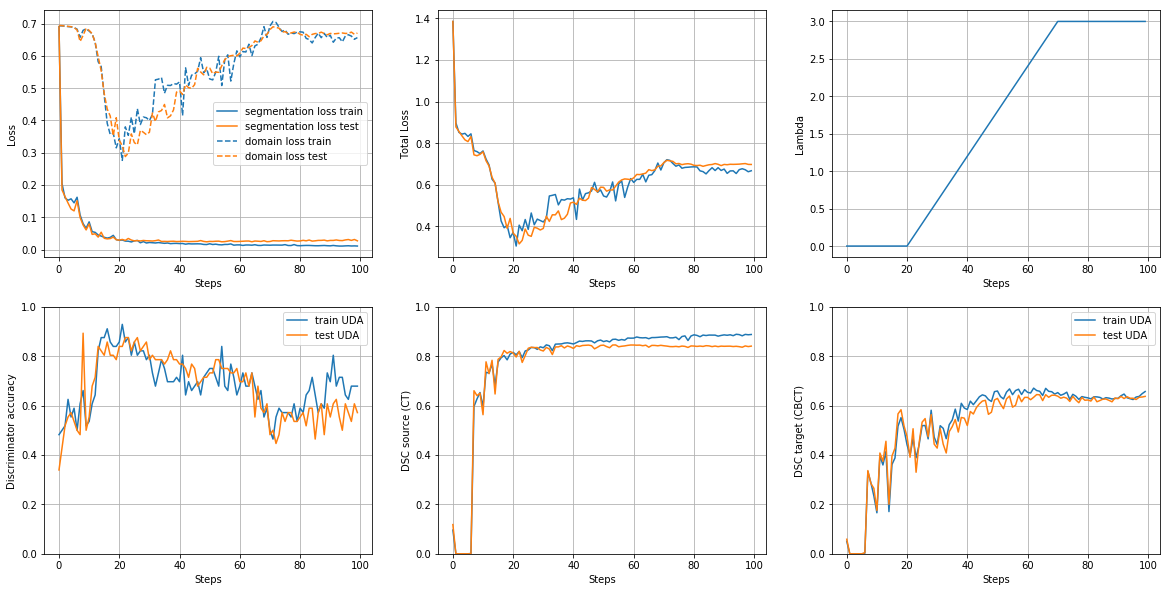

In [8]:
plt.figure(figsize=(20,10), frameon=False)

if training_mode=='source' or training_mode=='target':
    plt.subplot(2,3,1)
    plt.plot(mydict['loss_smooth'], color='#1f77b4', label='segmentation loss')
    plt.ylabel('Loss')
    plt.xlabel('Steps')
    plt.grid()
    plt.legend()
    
    plt.subplot(2,3,2)
    plt.plot(mydict['dice_ct_train'], label='train')
    plt.plot(mydict['dice_ct_test'], label='test')
    plt.ylabel('DSC source (CT)')
    plt.xlabel('Steps')
    plt.ylim([0,1])
    plt.legend()
    plt.grid()
    
    plt.subplot(2,3,3)
    plt.plot(mydict['dice_cbct_train'], color='#1f77b4', label='train')
    plt.plot(mydict['dice_cbct_test'], color='#ff7f0e', label='test')
    plt.legend()
    plt.ylabel('DSC target (CBCT)')
    plt.xlabel('Steps')
    plt.ylim([0,1])
    plt.grid()


else:
    plt.subplot(2,3,1)
    plt.plot(mydict['pred_loss_train'], color='#1f77b4', label='segmentation loss train')
    plt.plot(mydict['pred_loss_test'], color='#ff7f0e', label='segmentation loss test')
    plt.plot(mydict['domain_loss_train'], color='#1f77b4', linestyle='--', label='domain loss train')
    plt.plot(mydict['domain_loss_test'], color='#ff7f0e', linestyle='--', label='domain loss test')
    plt.ylabel('Loss')
    plt.xlabel('Steps')
    plt.grid()
    plt.legend()

    plt.subplot(2,3,2)
    y = [mydict['pred_loss_train'][i]+mydict['domain_loss_train'][i] for i in range(params['num_steps']//100)]
    plt.plot(y)
    y = [mydict['pred_loss_test'][i]+mydict['domain_loss_test'][i] for i in range(params['num_steps']//100)]
    plt.plot(y)
    plt.ylabel('Total Loss')
    plt.xlabel('Steps')
    plt.grid()

    plt.subplot(2,3,3)
    plt.plot(mydict['l'][:params['num_steps']//100])
    plt.ylabel('Lambda')
    plt.grid()
    plt.xlabel('Steps')

    plt.subplot(2,3,4)
    plt.plot(mydict['d_acc_train'], color='#1f77b4', label='train UDA')
    plt.plot(mydict['d_acc_test'], color='#ff7f0e', label='test UDA')
    plt.ylabel('Discriminator accuracy')
    plt.ylim([0,1])
    plt.xlabel('Steps')
    plt.grid()
    plt.legend()
    
    plt.subplot(2,3,5)
    plt.plot(mydict['dice_ct_train'])
    plt.plot(mydict['dice_ct_test'])
    plt.ylabel('DSC source (CT)')
    plt.ylim([0,1])
    plt.xlabel('Steps')
    plt.grid()
    
    plt.subplot(2,3,6)
    plt.plot(mydict['dice_cbct_train'], color='#1f77b4', label='train UDA')
    plt.plot(mydict['dice_cbct_test'], color='#ff7f0e', label='test UDA')
    plt.legend()
    plt.ylabel('DSC target (CBCT)')
    plt.ylim([0,1])
    plt.xlabel('Steps')
    plt.grid()

filepath = '/home/cuxartgarcia/unet_uda_29-4-20/results/' + params2name(params) + '/learning_curves.eps'
plt.savefig(filepath)

## DICE CBCT standard deviation

### DANN

In [8]:
print(total_dice_dann)
print(len(total_dice_dann))
print(statistics.stdev(total_dice_dann))

[0.7518632178868917, 0.4478554009467795, 0.8369938741969221, 0.7940204110967372, 0.748160969277369, 0.6371571072319202, 0.6540832049306626, 0.4492020241339042, 0.5339908418457203, 0.34184882802212274, 0.8313181367690782, 0.7165651290977662, 0.7824333408021511, 0.8271036012971497, 0.7589251439539347, 0.7488648271044359, 0.7918570835064396, 0.7691029900332226, 0.4565640825866771, 0.7705163916863083, 0.7146087743102668, 0.6922183507549362, 0.4857842214272265, 0.8448604060913705, 0.6000000000000001, 0.6228513650151669, 0.8465991316931983, 0.7154178674351584]
28
0.14181437622555218


### SOURCE

In [9]:
print(total_dice_source)
print(len(total_dice_source))
print(statistics.stdev(total_dice_source))

[0.3782866836301951, 0.43100189035916825, 0.17023471756512767, 0.23610243597751404, 0.1252878857669277, 0.42148198504418766, 0.301464254952627, 0.41081081081081083, 0.0, 0.0345821325648415, 0.8, 0.4970995091477019, 0.8359678673231408, 0.8354881854658939, 0.5040691759918616, 0.773453502662843, 0.8453514739229026, 0.43260025873221214, 0.1953532479848269, 0.6135752688172044, 0.5749525616698292, 0.18222722159730034, 0.6400536732640054, 0.08813559322033898, 0.38368139873725104, 0.130952380952381, 0.5025701277720663, 0.03398692810457517]
28
0.26496872860473075


### TARGET

In [8]:
print(total_dice_target)
print(len(total_dice_target))
print(statistics.stdev(total_dice_target))

[0.8969603297269448, 0.8291267769074557, 0.9245435016111708, 0.90529638723255, 0.8690559850081986, 0.9011957205789806, 0.7997107736804049, 0.8337662337662337, 0.7581989994441357, 0.0, 0.853318250377074, 0.7982289690069575, 0.7352721849366144, 0.8780867198133385, 0.8519440124416796, 0.6709970769730432, 0.5979438732981384, 0.900197806149973, 0.6008037508372404, 0.8248407643312102, 0.749597423510467, 0.8494208494208495, 0.6276958002270148, 0.7964570416297608, 0.7294117647058823, 0.6502963590177815, 0.9092743970128166, 0.7766575007638252]
28
0.17900757297724285


## BOXPLOT 

## Boxplot DSC

In [9]:
import matplotlib as mpl 
mpl.use('agg')  

import matplotlib.pyplot as plt 

dice_test_dann = [0.7518632178868917, 0.4478554009467795, 0.8369938741969221, 0.7940204110967372, 0.748160969277369, 0.6371571072319202, 0.6540832049306626, 0.4492020241339042, 0.5339908418457203, 0.34184882802212274, 0.8313181367690782, 0.7165651290977662, 0.7824333408021511, 0.8271036012971497, 0.7589251439539347, 0.7488648271044359, 0.7918570835064396, 0.7691029900332226, 0.4565640825866771, 0.7705163916863083, 0.7146087743102668, 0.6922183507549362, 0.4857842214272265, 0.8448604060913705, 0.6000000000000001, 0.6228513650151669, 0.8465991316931983, 0.7154178674351584]
dice_test_source = [0.4287464271131074, 0.5024533856722276, 0.2704678362573099, 0.3175065540343723, 0.18020417221482468, 0.3817797605071613, 0.29574531389467423, 0.45329849771391245, 0.0, 0.060209424083769635, 0.8089775561097257, 0.49978041282389113, 0.8151823368891095, 0.8450143709927039, 0.4482481947044664, 0.7816, 0.8249660786974219, 0.47719470328592445, 0.3490280777537797, 0.6582518144525087, 0.6550137994480222, 0.13557358053302435, 0.5912627169359664, 0.10837988826815644, 0.35909980430528377, 0.34177215189873417, 0.5935733002344504, 0.018469656992084433]
dice_test_target =[0.8969603297269448, 0.8291267769074557, 0.9245435016111708, 0.90529638723255, 0.8690559850081986, 0.9011957205789806, 0.7997107736804049, 0.8337662337662337, 0.7581989994441357, 0.0, 0.853318250377074, 0.7982289690069575, 0.7352721849366144, 0.8780867198133385, 0.8519440124416796, 0.6709970769730432, 0.5979438732981384, 0.900197806149973, 0.6008037508372404, 0.8248407643312102, 0.749597423510467, 0.8494208494208495, 0.6276958002270148, 0.7964570416297608, 0.7294117647058823, 0.6502963590177815, 0.9092743970128166, 0.7766575007638252]

# Combine these different collections into a list    
test = [dice_test_source, dice_test_target, dice_test_dann]

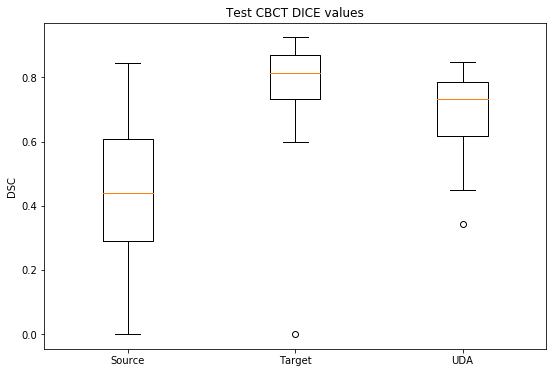

In [11]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(test)
ax.set_xticklabels(['Source', 'Target', 'UDA'])
ax.set_ylabel('DSC')
plt.title('Test CBCT DICE values')

# Save the figure
fig.savefig('dice_test.eps', bbox_inches='tight')

## Boxplot hausdorff distance 

In [13]:
import matplotlib as mpl 
mpl.use('agg')  

import matplotlib.pyplot as plt 

distance_test_source = [46.93179535082373, 46.93179535082373, 46.93179535082373, 46.93179535082373, 37.93276273901331, 37.93276273901331, 37.93276273901331, 37.93276273901331, 30.27113425213117, 30.27113425213117, 30.27113425213117, 30.27113425213117, 32.408168995591545, 32.408168995591545, 32.408168995591545, 32.408168995591545, 29.31327172104418, 29.31327172104418, 29.31327172104418, 29.31327172104418, 35.65572127104842, 35.65572127104842, 35.65572127104842, 35.65572127104842, 39.06113267750002, 39.06113267750002, 39.06113267750002, 39.06113267750002]
distance_test_target = [22.179845578560073, 22.179845578560073, 22.179845578560073, 22.179845578560073, 26.93063690217449, 26.93063690217449, 26.93063690217449, 26.93063690217449, 26.873085145216542, 26.873085145216542, 26.873085145216542, 26.873085145216542, 35.550538849569946, 35.550538849569946, 35.550538849569946, 35.550538849569946, 33.26890997892843, 33.26890997892843, 33.26890997892843, 33.26890997892843, 34.52187886570834, 34.52187886570834, 34.52187886570834, 34.52187886570834, 28.817783498854958, 28.817783498854958, 28.817783498854958, 28.817783498854958]
distance_test_dann = [58.22965742798326, 58.22965742798326, 58.22965742798326, 58.22965742798326, 47.04841979783639, 47.04841979783639, 47.04841979783639, 47.04841979783639, 30.75889134148539, 30.75889134148539, 30.75889134148539, 30.75889134148539, 30.50900088485311, 30.50900088485311, 30.50900088485311, 30.50900088485311, 31.753899928296775, 31.753899928296775, 31.753899928296775, 31.753899928296775, 47.929530243248145, 47.929530243248145, 47.929530243248145, 47.929530243248145, 40.72997467570722, 40.72997467570722, 40.72997467570722, 40.72997467570722]

# Combine these different collections into a list    
test = [distance_test_source, distance_test_target, distance_test_dann]

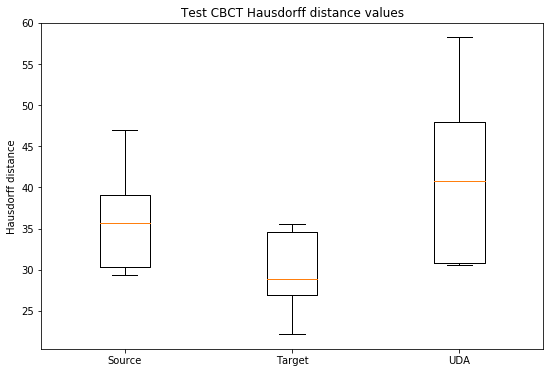

In [14]:
# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))
# Create an axes instance
ax = fig.add_subplot(111)
# Create the boxplot
bp = ax.boxplot(test)
ax.set_xticklabels(['Source', 'Target', 'UDA'])
ax.set_ylabel('Hausdorff distance')
plt.title('Test CBCT Hausdorff distance values')

# Save the figure
fig.savefig('hausdorff_boxplot.eps', bbox_inches='tight')

# Print contours and compute distances

In [9]:
import imageio
import cv2
from scipy.misc import toimage, imsave
from PIL import Image
from scipy.spatial.distance import cdist
from scipy.misc import imfilter

list_slices = [5,8,11]
organ_num = 0
spacing = [4.8, 4.8, 6]
distance_list_source = []
distance_list_target = []
distance_list_dann = []

def Hausdorff_dist(vol_a,vol_b):
    dist_lst = []
    for idx in range(len(vol_a)):
        dist_min = 1000.0        
        for idx2 in range(len(vol_b)):
            dist= np.linalg.norm(vol_a[idx]-vol_b[idx2])
            if dist_min > dist:
                dist_min = dist
        dist_lst.append(dist_min)
    return np.max(dist_lst)


## SOURCE

/export/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # Remove the CWD from sys.path while we load stuff.
/export/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # This is added back by InteractiveShellApp.init_path()
/export/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  if sys.path[0] == '':
/export/share/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.p

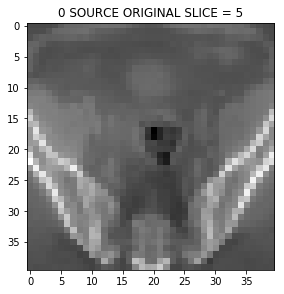

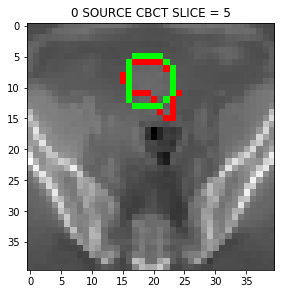

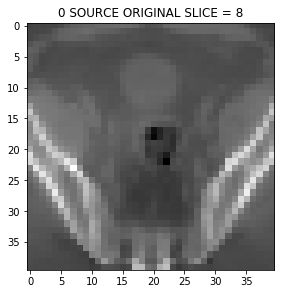

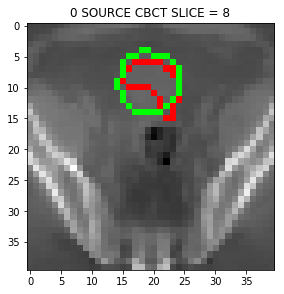

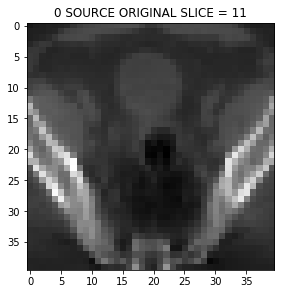

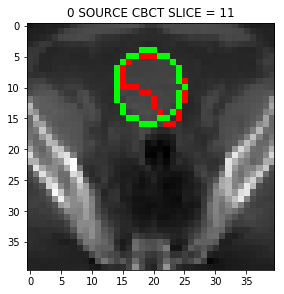

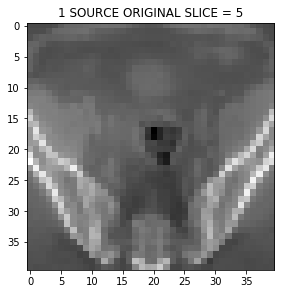

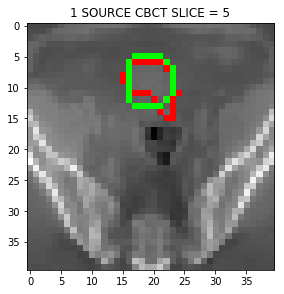

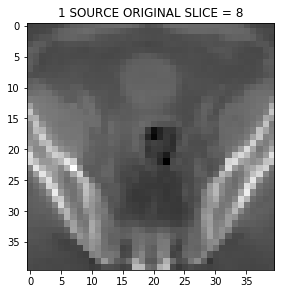

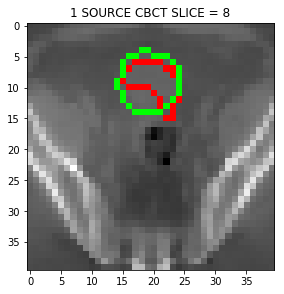

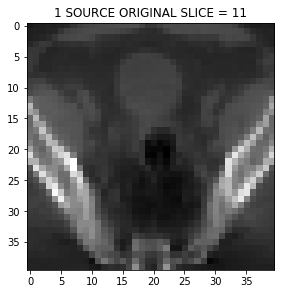

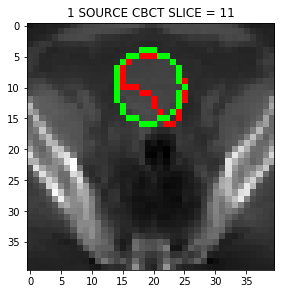

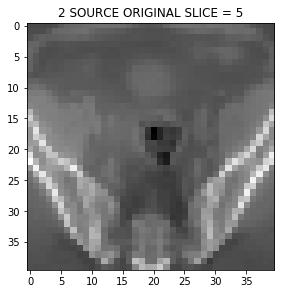

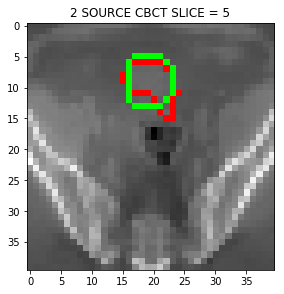

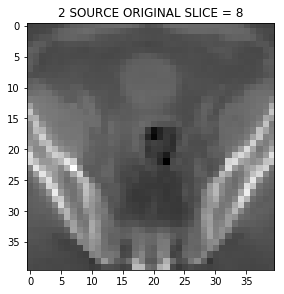

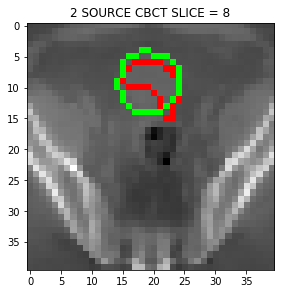

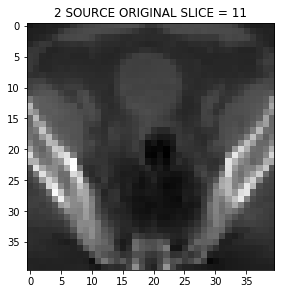

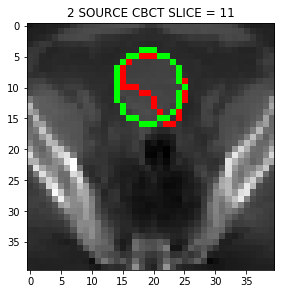

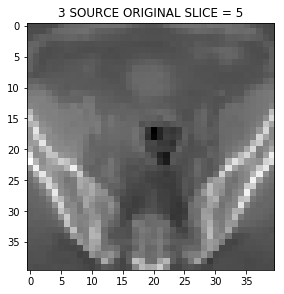

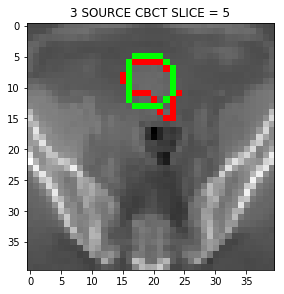

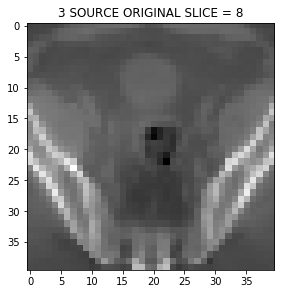

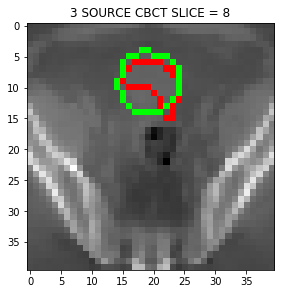

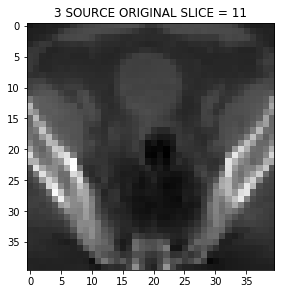

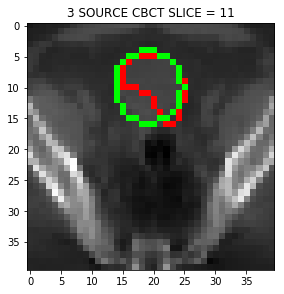

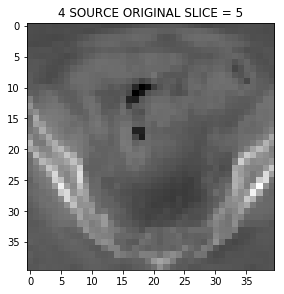

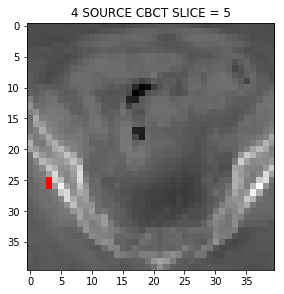

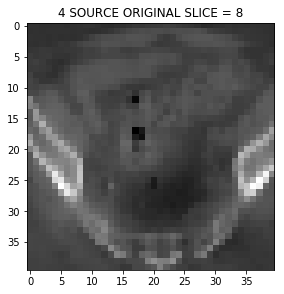

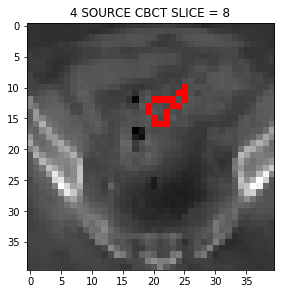

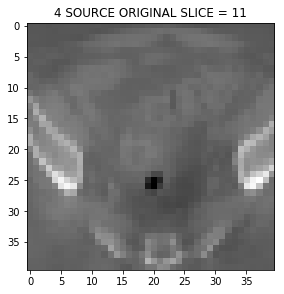

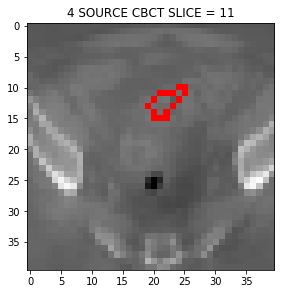

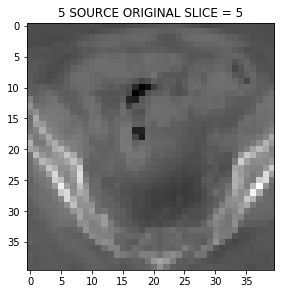

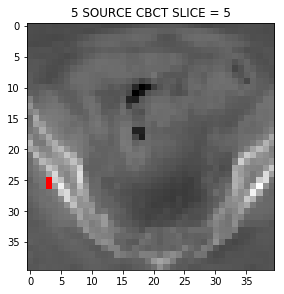

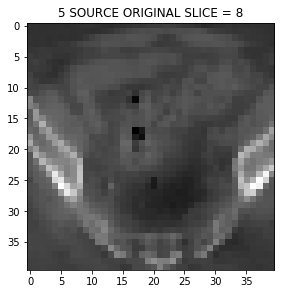

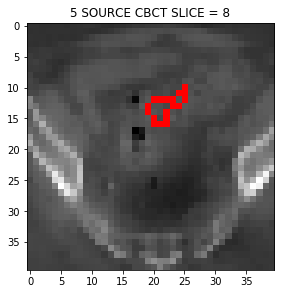

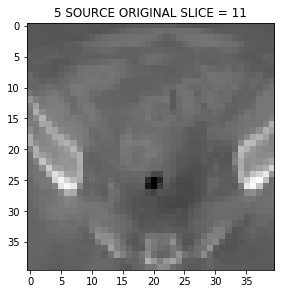

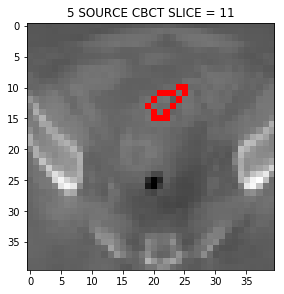

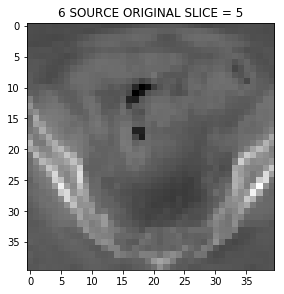

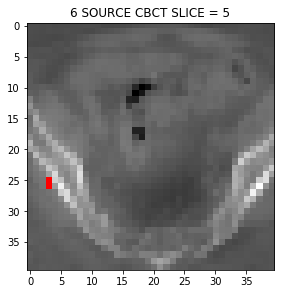

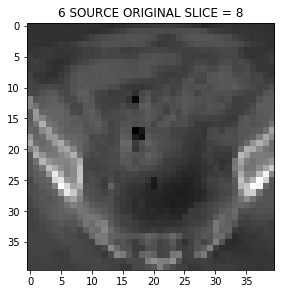

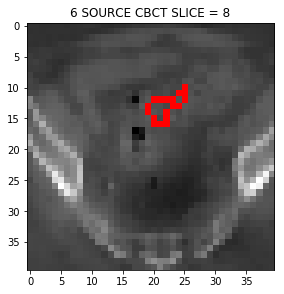

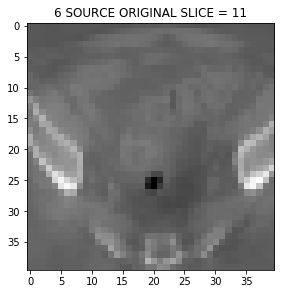

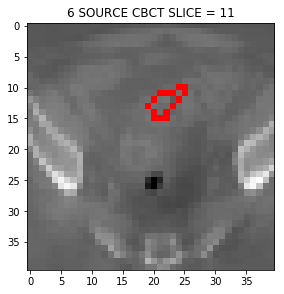

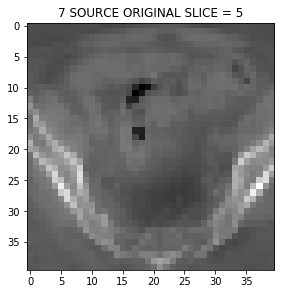

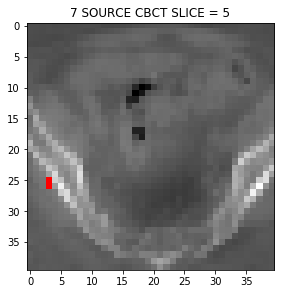

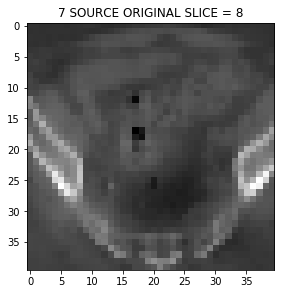

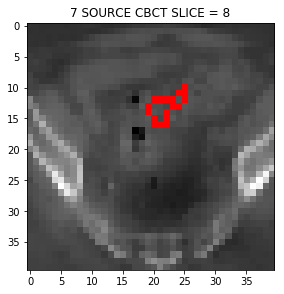

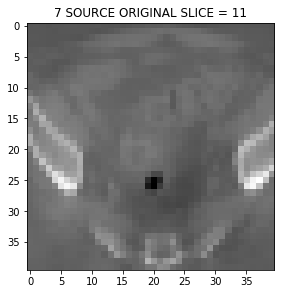

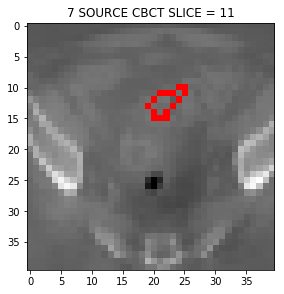

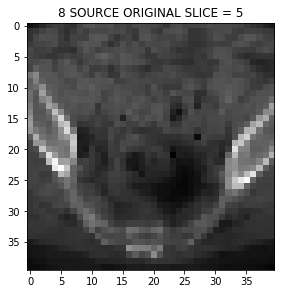

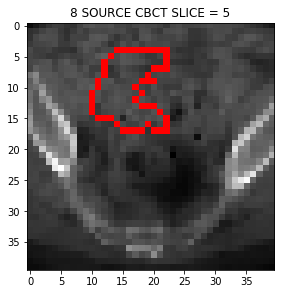

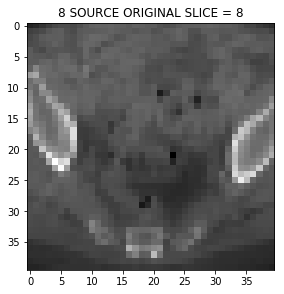

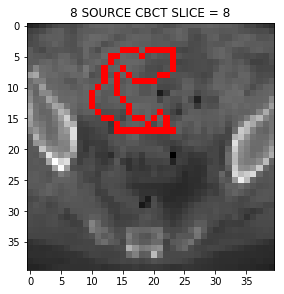

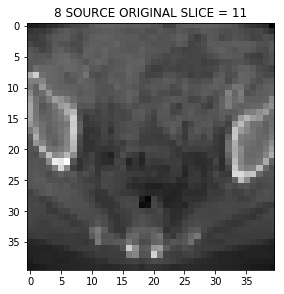

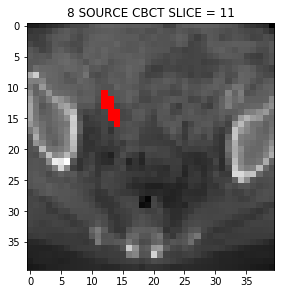

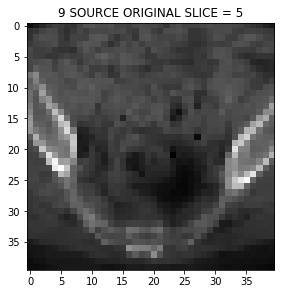

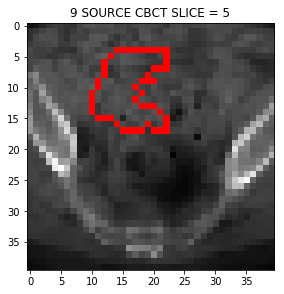

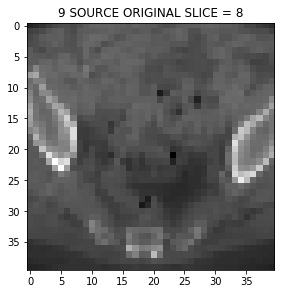

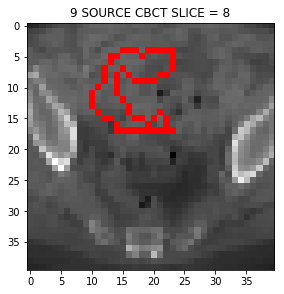

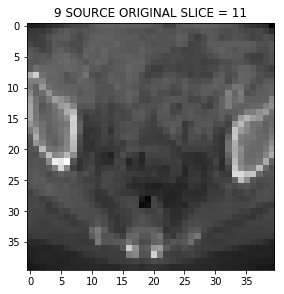

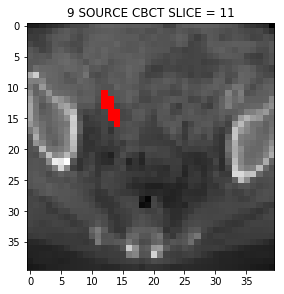

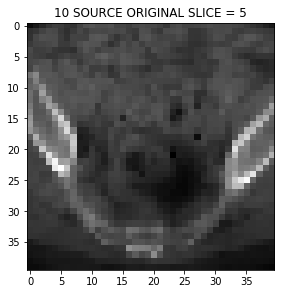

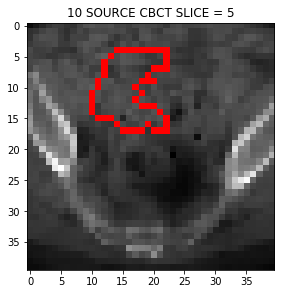

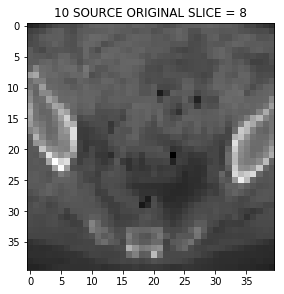

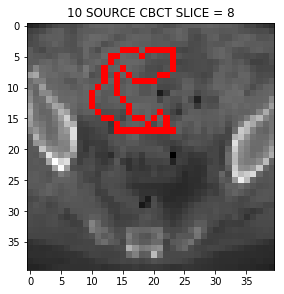

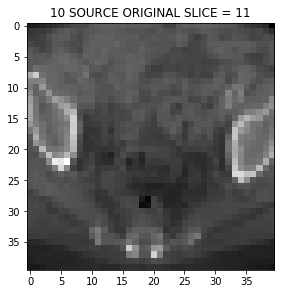

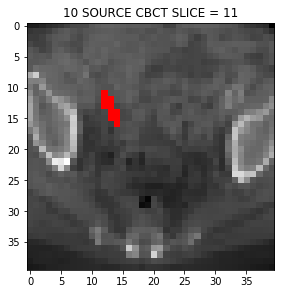

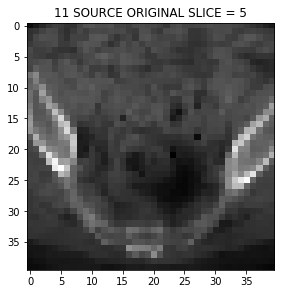

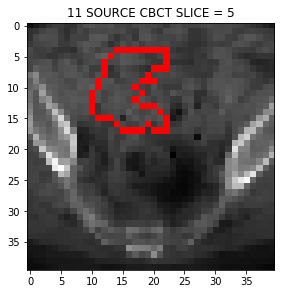

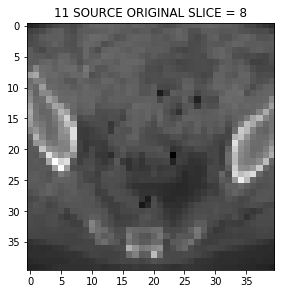

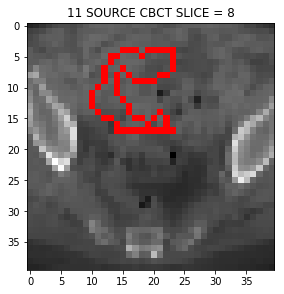

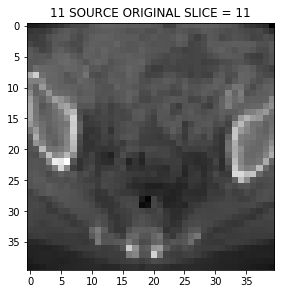

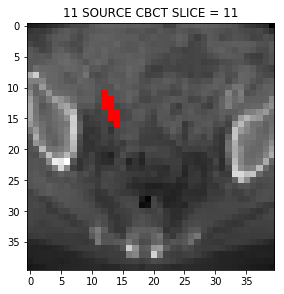

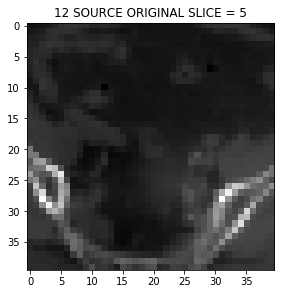

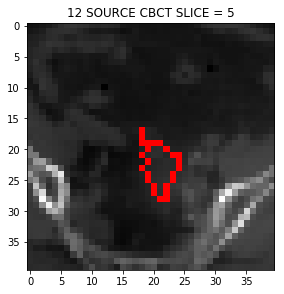

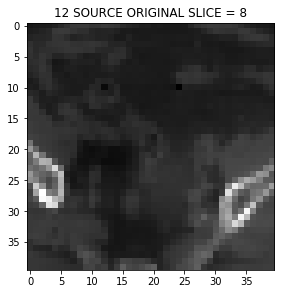

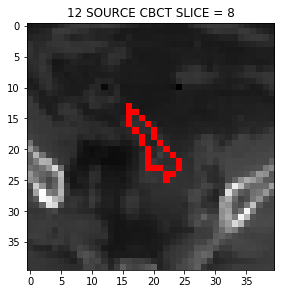

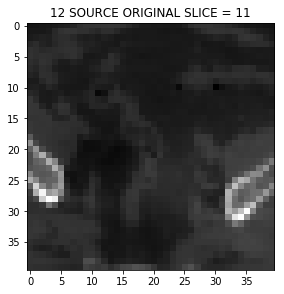

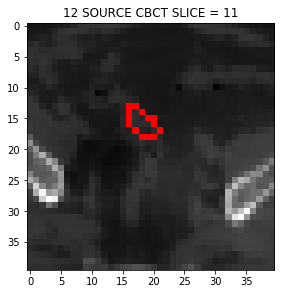

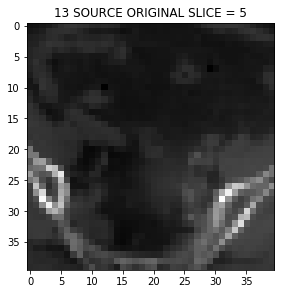

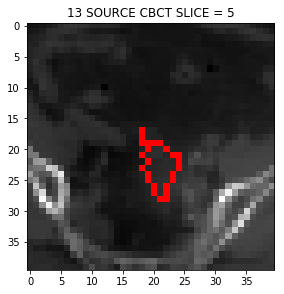

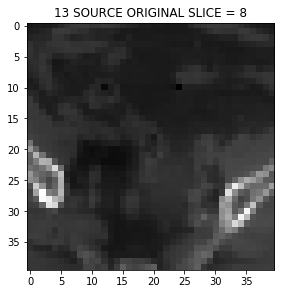

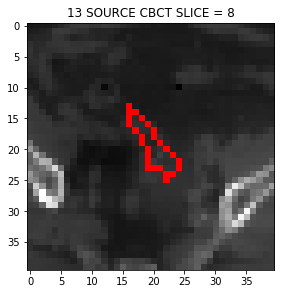

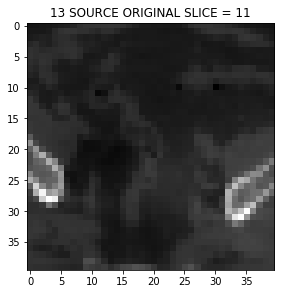

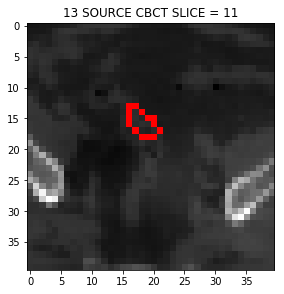

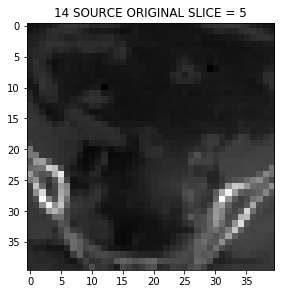

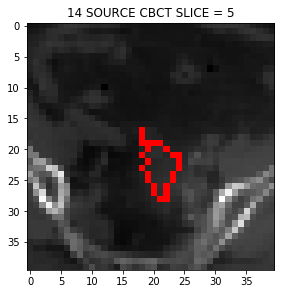

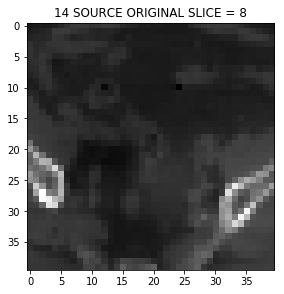

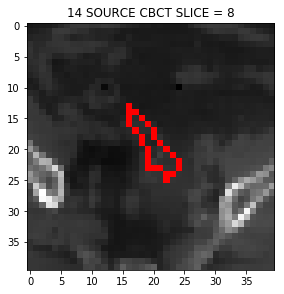

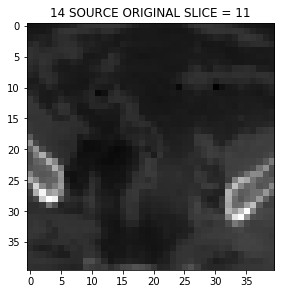

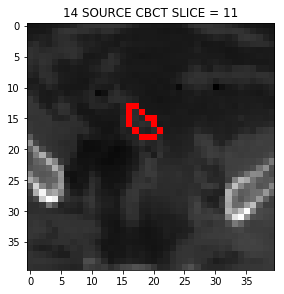

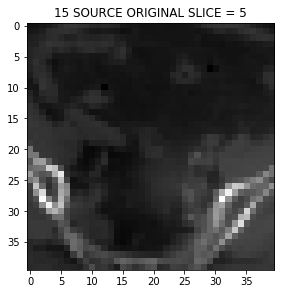

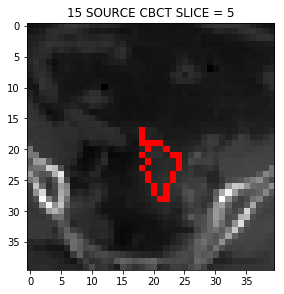

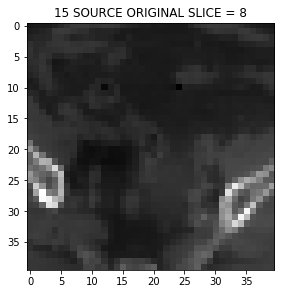

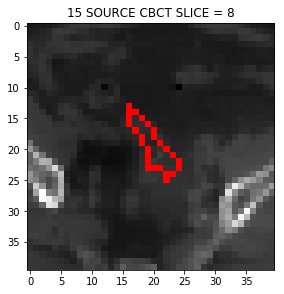

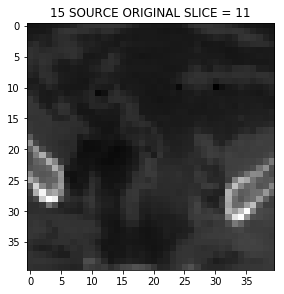

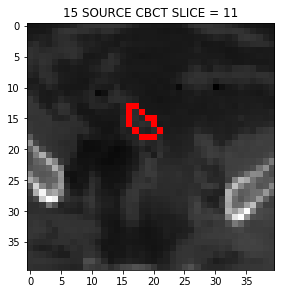

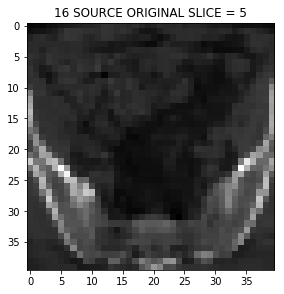

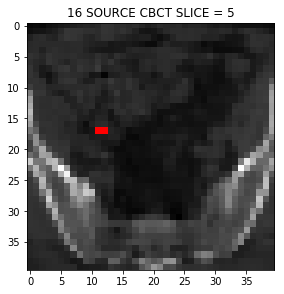

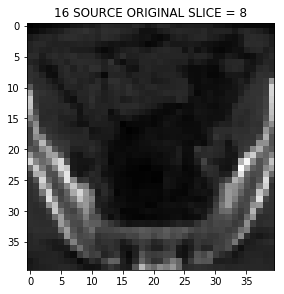

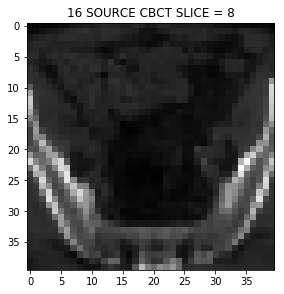

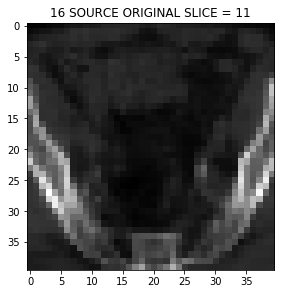

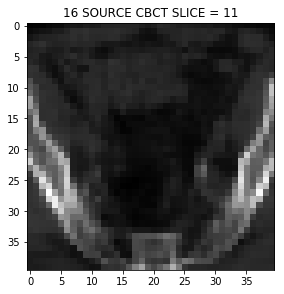

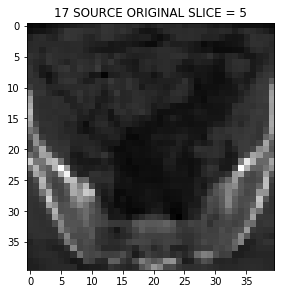

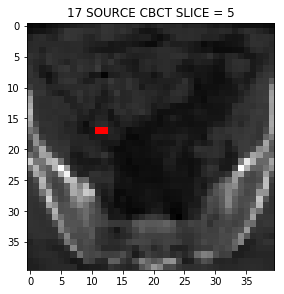

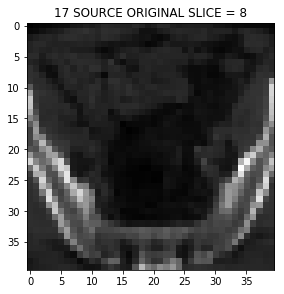

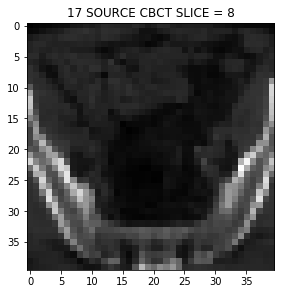

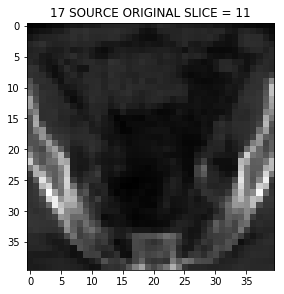

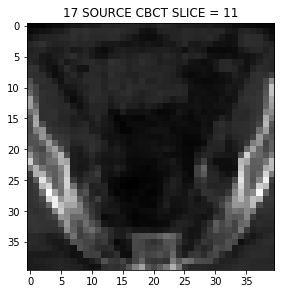

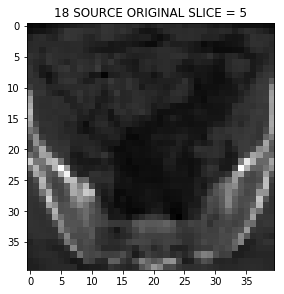

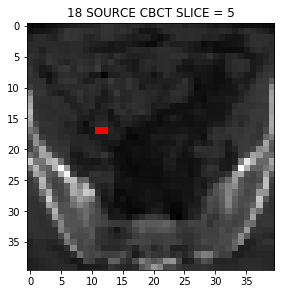

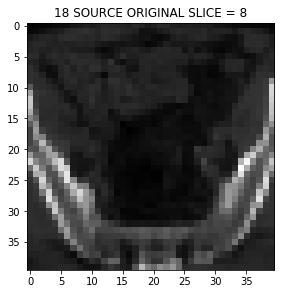

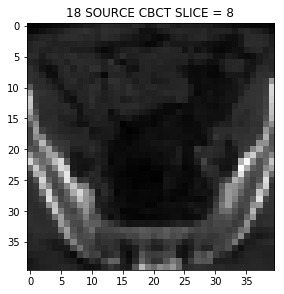

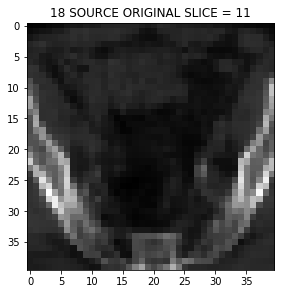

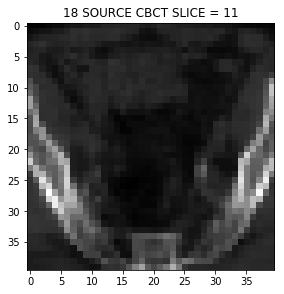

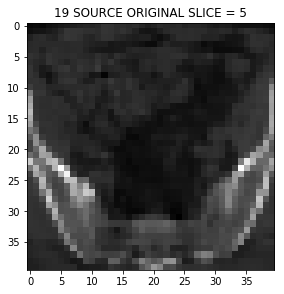

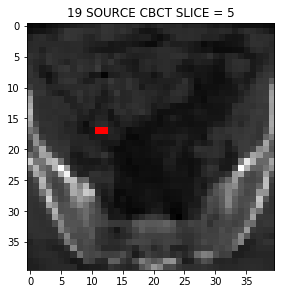

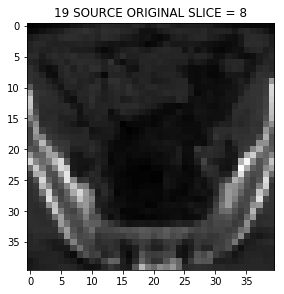

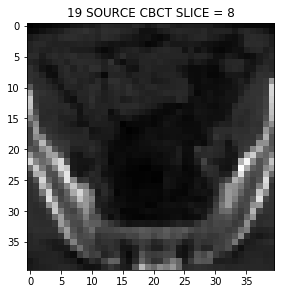

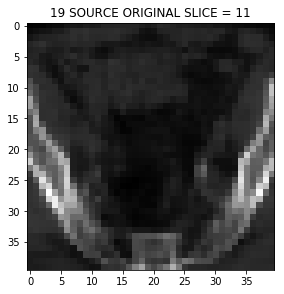

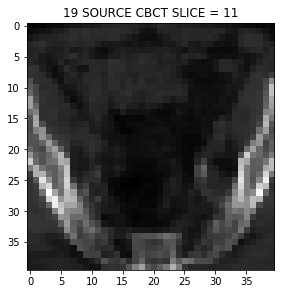

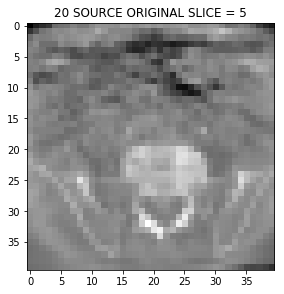

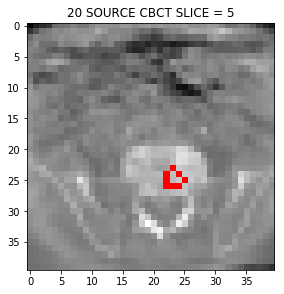

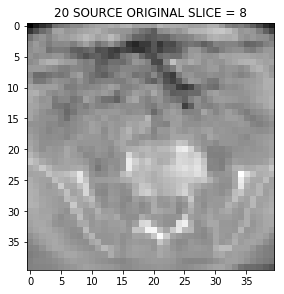

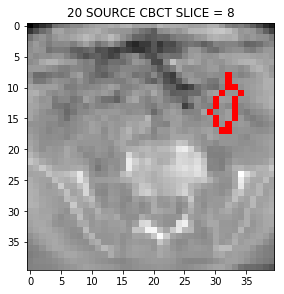

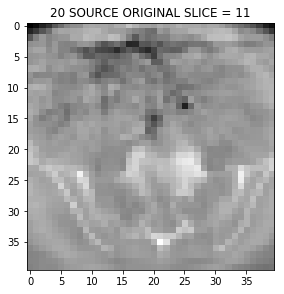

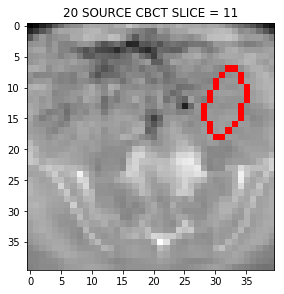

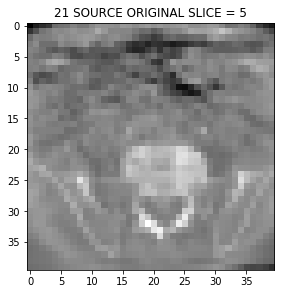

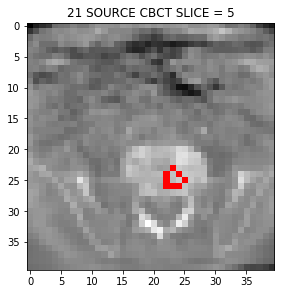

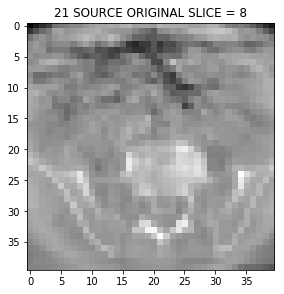

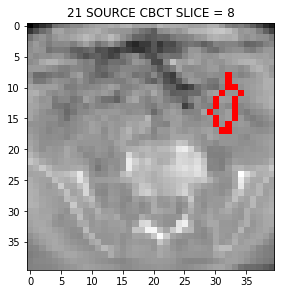

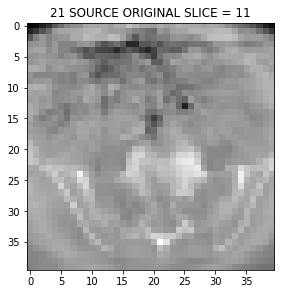

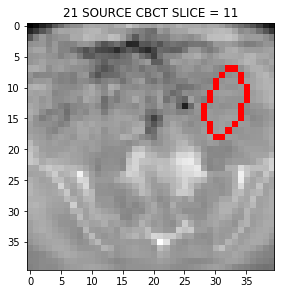

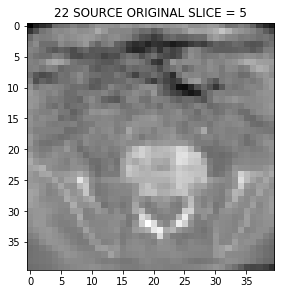

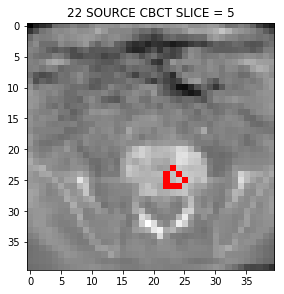

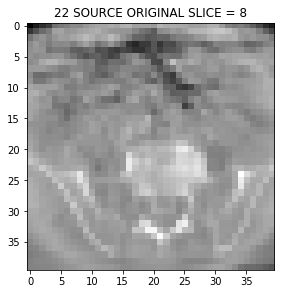

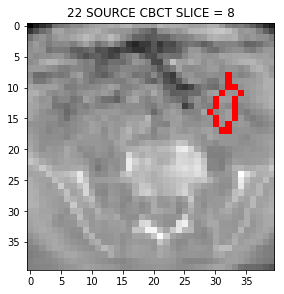

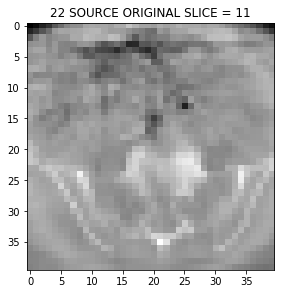

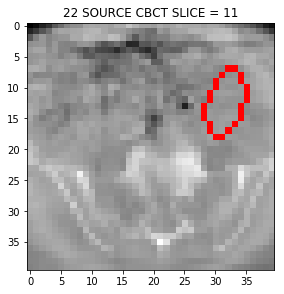

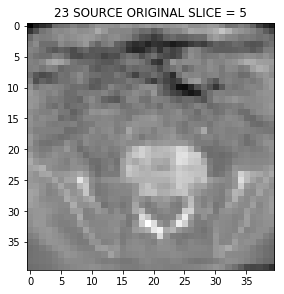

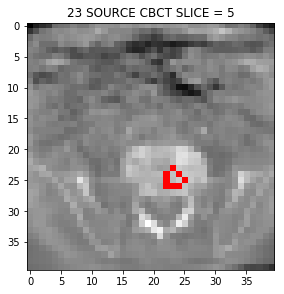

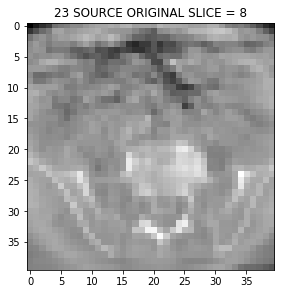

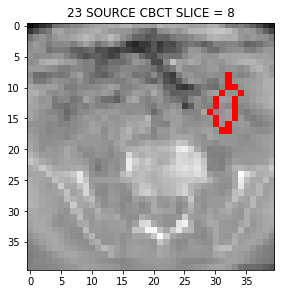

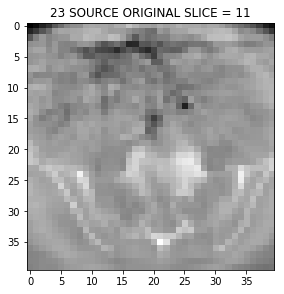

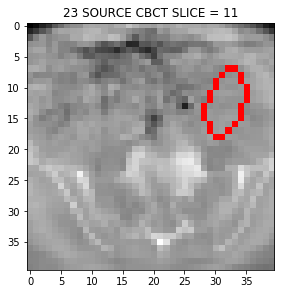

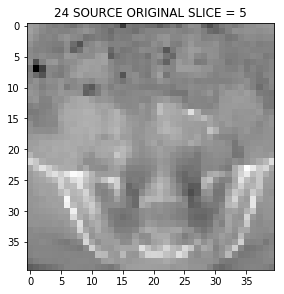

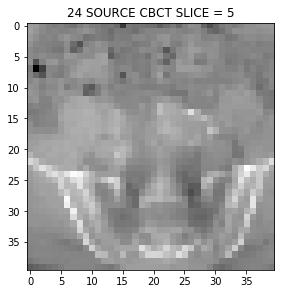

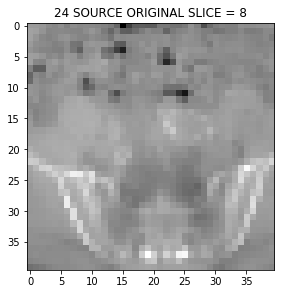

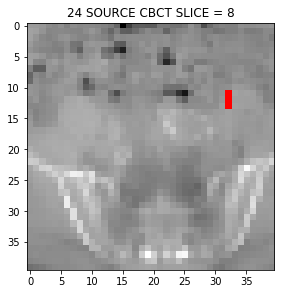

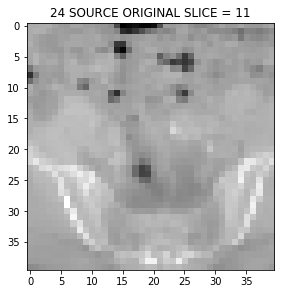

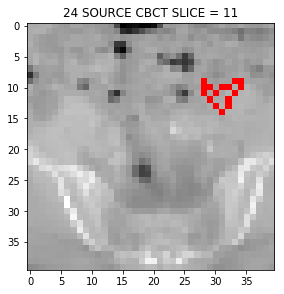

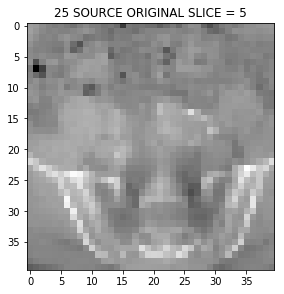

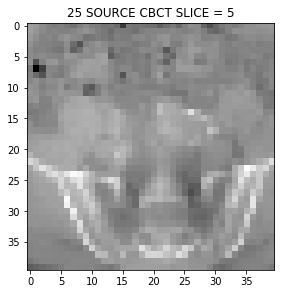

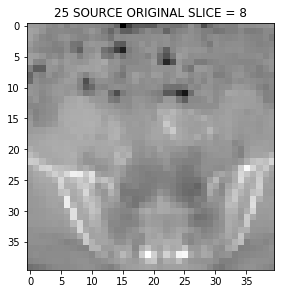

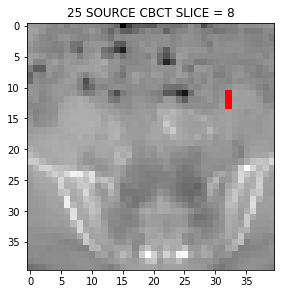

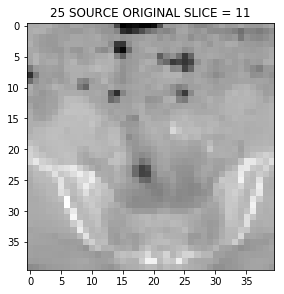

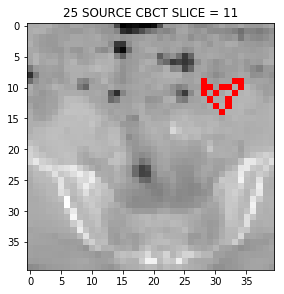

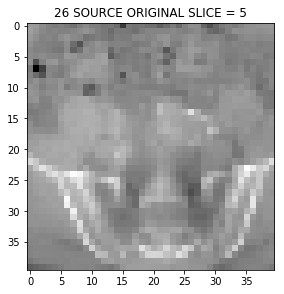

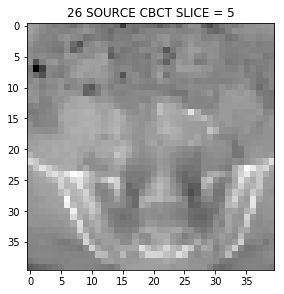

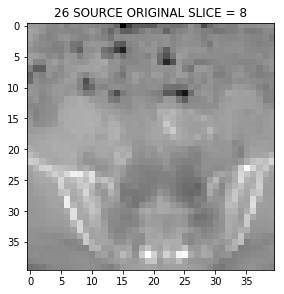

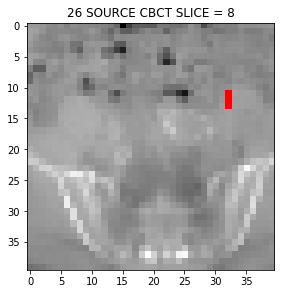

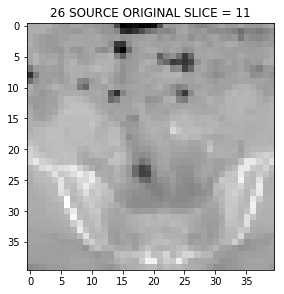

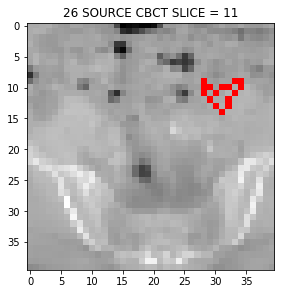

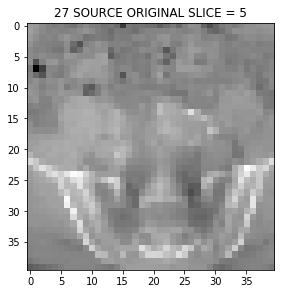

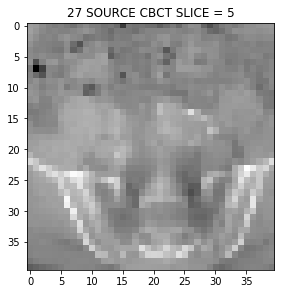

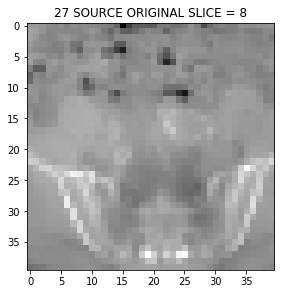

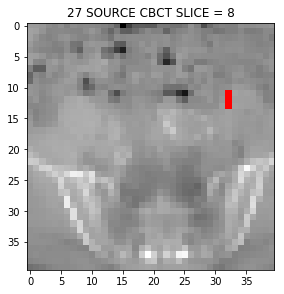

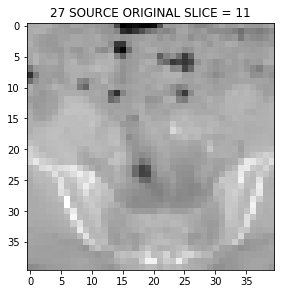

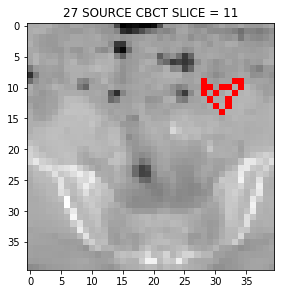

In [10]:
for d in range(len(total_dice_source)):
    
    #Compute distance
    h_dist = 0
    h_dist = Hausdorff_dist(total_pred_masks_source[d],total_original_masks_source[d])
    
    for s in range(len(list_slices)):
        
        # Save np images as .png
        imsave("./closest_pred_mask_source.png".format(), total_pred_masks_source[d][organ_num,:,:,s])
        imsave("./closest_pred_image_source.png".format(), total_original_images_source[d][organ_num,:,:,s,0])
        imsave("./closest_original_mask_source.png".format(), total_original_masks_source[d][organ_num,:,:,s])

        image_original = cv2.imread("closest_pred_image_source.png")

        # Prepare contours ORIGINAL MASK
        mask_original = cv2.imread("closest_original_mask_source.png")
        gray_image_original_mask = cv2.cvtColor(mask_original, cv2.COLOR_BGR2GRAY)

        # Apply cv2.threshold() to get a binary image
        ret, thresh = cv2.threshold(gray_image_original_mask, 50, 255, cv2.THRESH_BINARY)

        # Find contours:
        im, contours_original, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


        # Prepare contours PREDICTED MASK
        mask_pred = cv2.imread("closest_pred_mask_source.png")
        gray_image_pred_mask = cv2.cvtColor(mask_pred, cv2.COLOR_BGR2GRAY)

        # Apply cv2.threshold() to get a binary image
        ret, thresh = cv2.threshold(gray_image_pred_mask, 50, 255, cv2.THRESH_BINARY)

        # Find contours:
        im, contours_pred, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        # Show image:
        plt.figure(figsize=(20,10), frameon=False)
        plt.subplot(2,2,2)
        plt.title(str(d)+' SOURCE ORIGINAL SLICE = '+str(list_slices[s]))
        plt.imshow(image_original)
        plt.savefig('./all/source/Original_SOURCE_'+str(d)+'_'+str(total_dice_source[d])+'_'+str(h_dist)+'_'+str(list_slices[s])+'.eps', bbox_inches='tight')

        # Draw contours:
        cv2.drawContours(image_original, contours_pred, 0, (255, 0, 0), 1)
        cv2.drawContours(image_original, contours_original, 0, (0, 255, 0), 1)

        # Show image:
        plt.figure(figsize=(20,10), frameon=False)
        plt.subplot(2,2,3)
        plt.title(str(d)+' SOURCE CBCT SLICE = '+str(list_slices[s]))
        plt.imshow(image_original)

        # Save the figure
        plt.savefig('./all/source/CBCT_SOURCE_'+str(d)+'_'+str(total_dice_source[d])+'_'+str(h_dist)+'_'+str(list_slices[s])+'.eps', bbox_inches='tight')


## TARGET

0.718972196962106
[0.8912702561421851, 0.8454960091220068, 0.9221940477779261, 0.8971477960242005, 0.8579374275782156, 0.9032967032967032, 0.7973390354003326, 0.86875, 0.7792207792207791, 0.0, 0.8454494487011774, 0.8, 0.7234904270986745, 0.8680981595092025, 0.8486720197652872, 0.6819822776501476, 0.6321090047393365, 0.9051663128096249, 0.6014686248331107, 0.8273051451859399, 0.7582373957919808, 0.859643217771794, 0.6157690172126596, 0.8202383008116043, 0.7081735025081145, 0.6288135593220339, 0.9078760882769792, 0.7740213523131674]


/export/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
/export/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app
/export/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  app.launch_new_instance()
/export/share/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

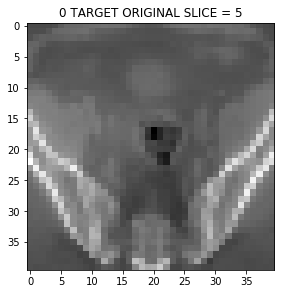

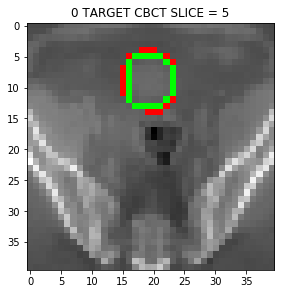

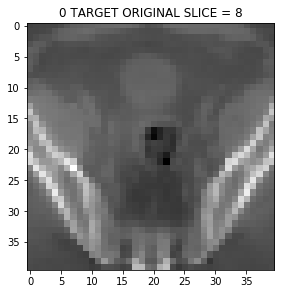

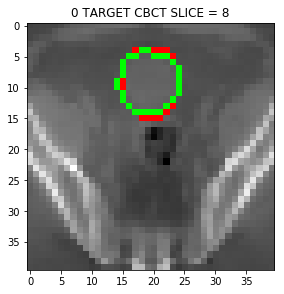

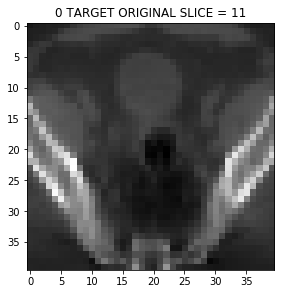

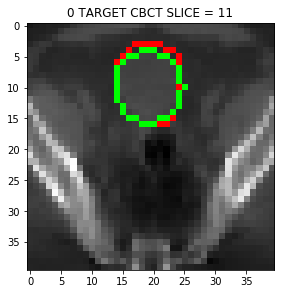

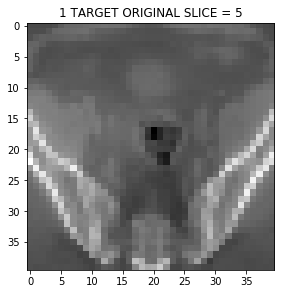

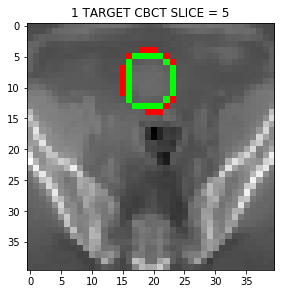

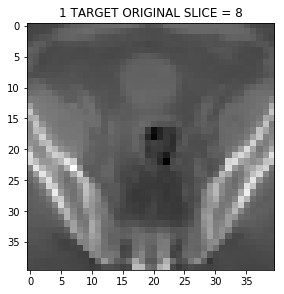

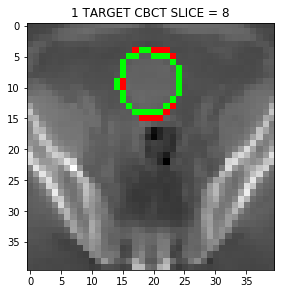

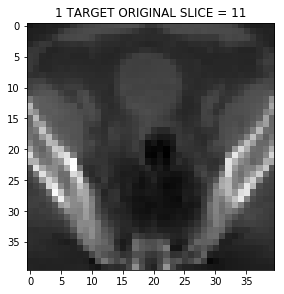

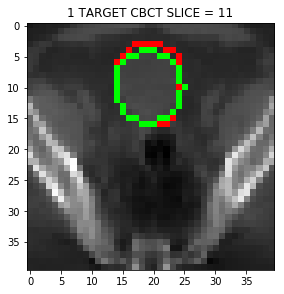

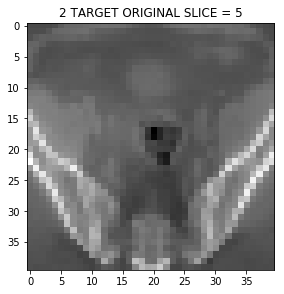

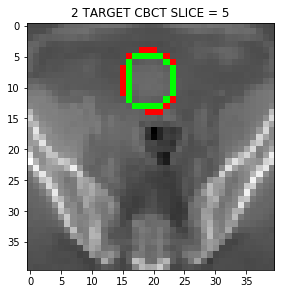

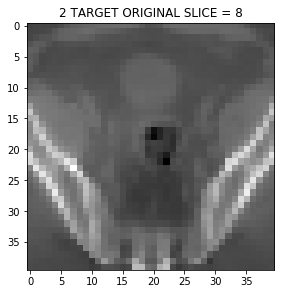

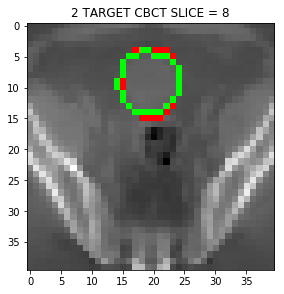

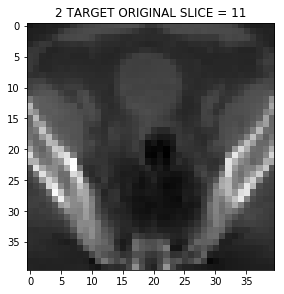

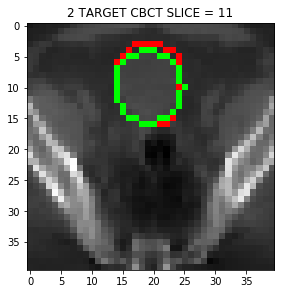

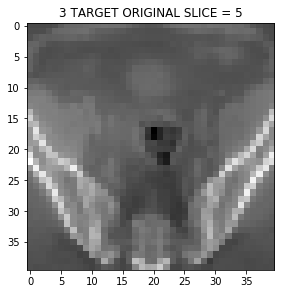

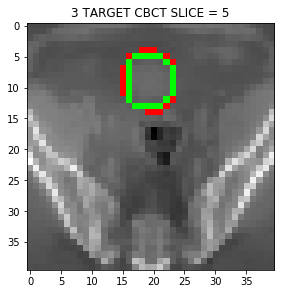

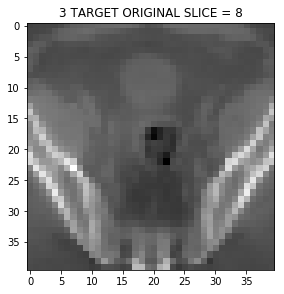

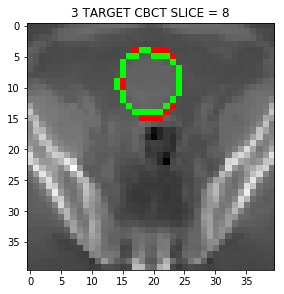

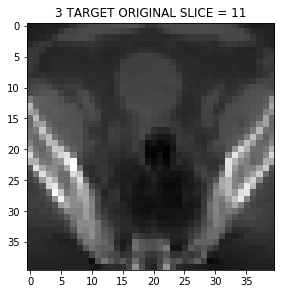

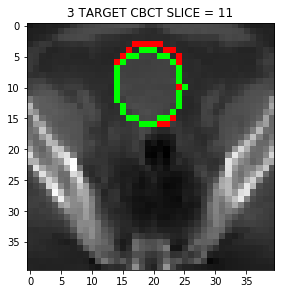

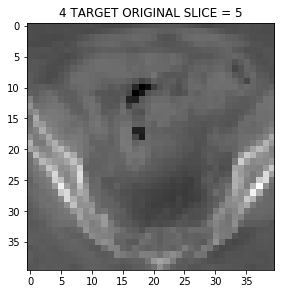

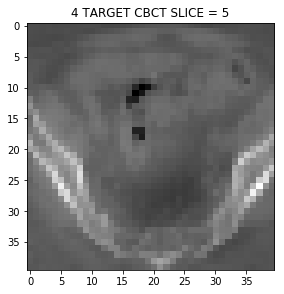

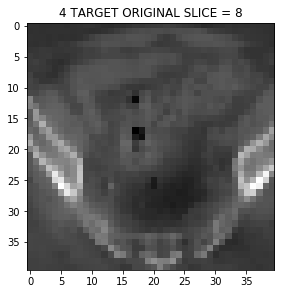

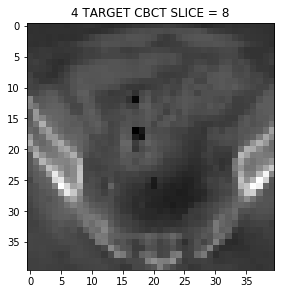

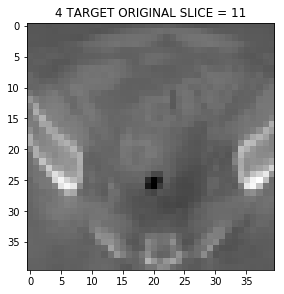

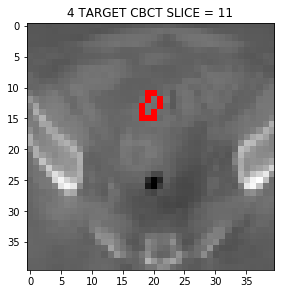

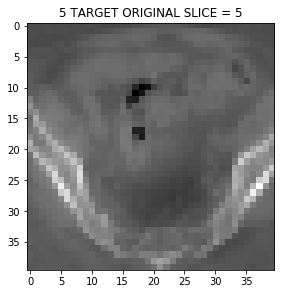

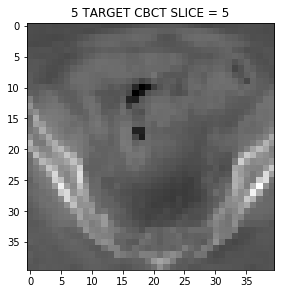

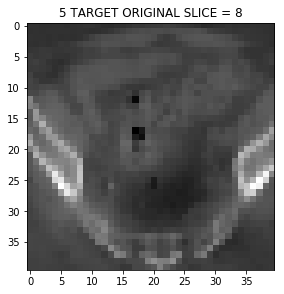

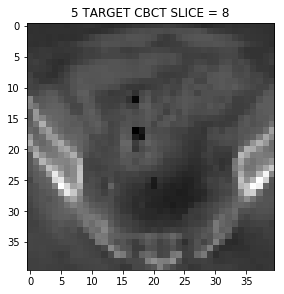

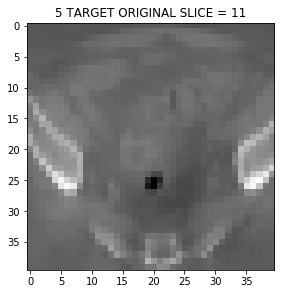

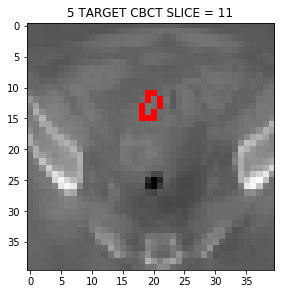

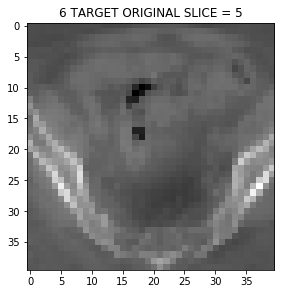

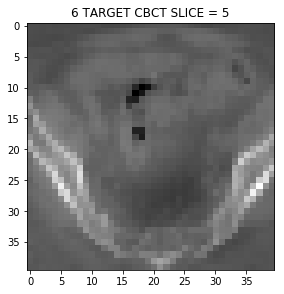

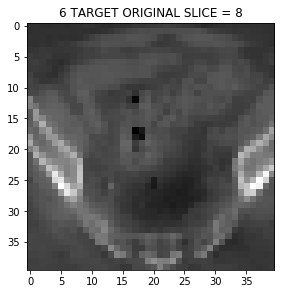

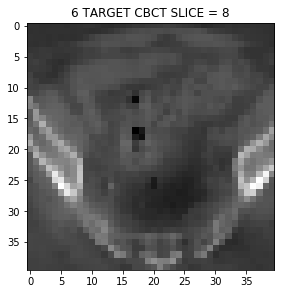

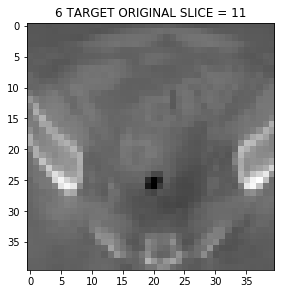

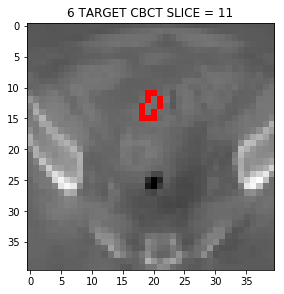

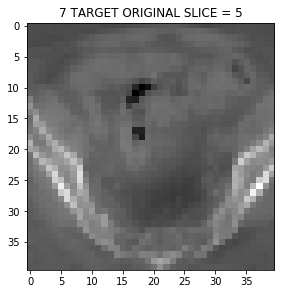

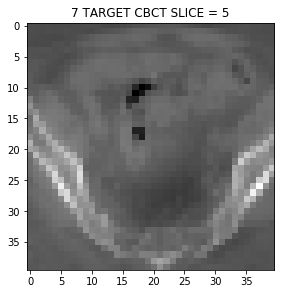

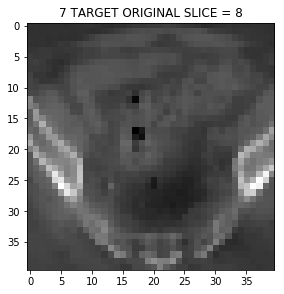

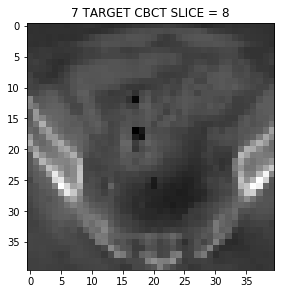

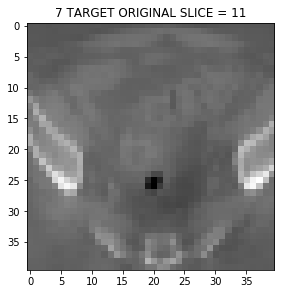

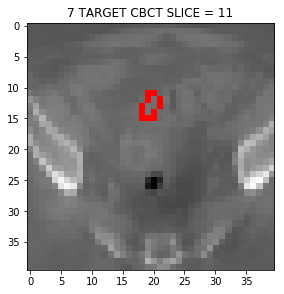

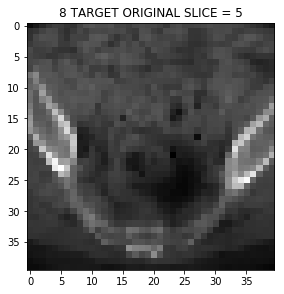

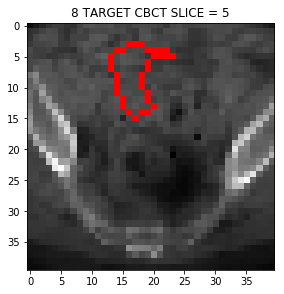

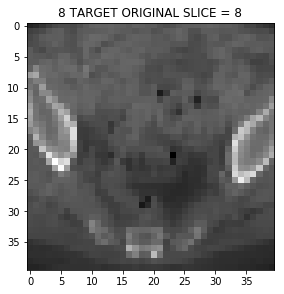

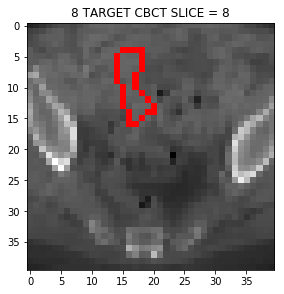

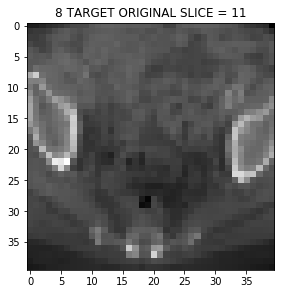

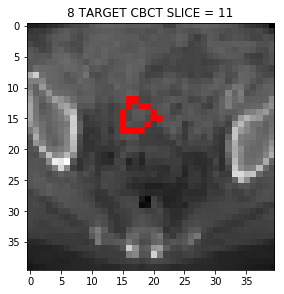

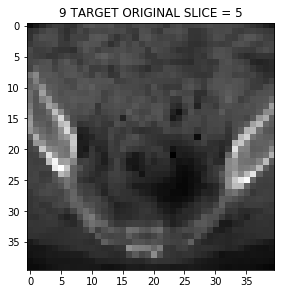

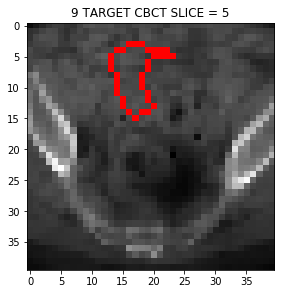

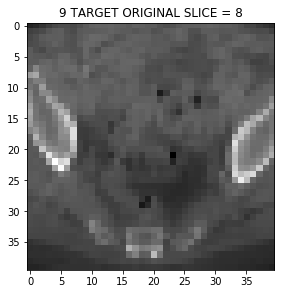

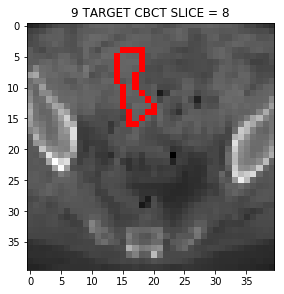

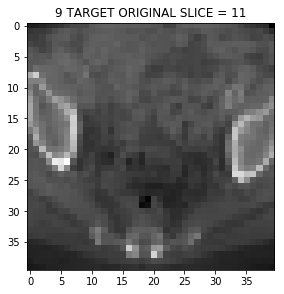

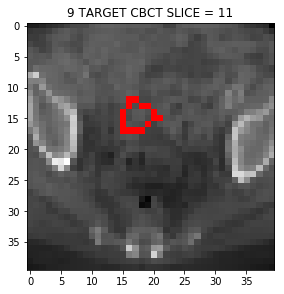

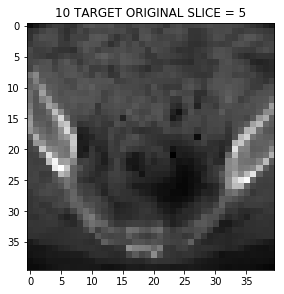

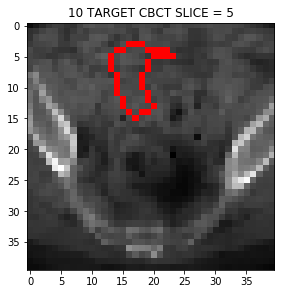

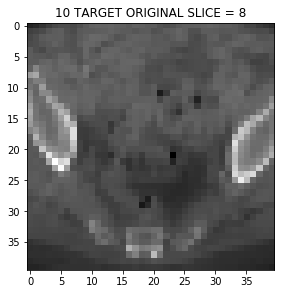

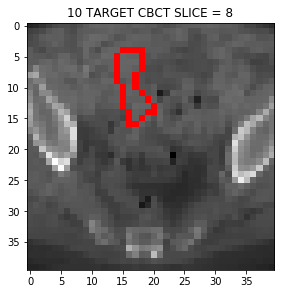

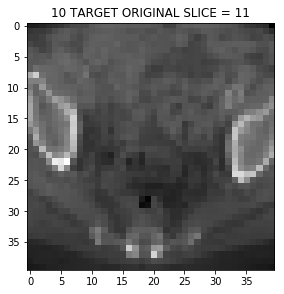

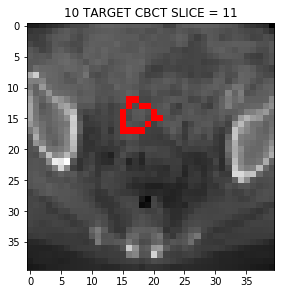

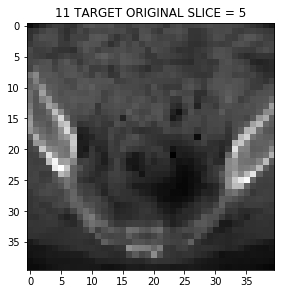

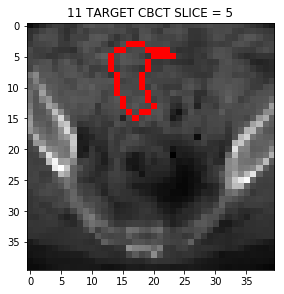

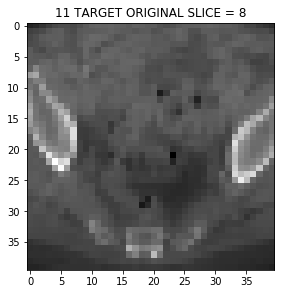

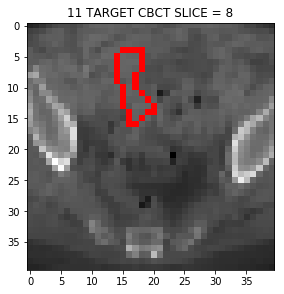

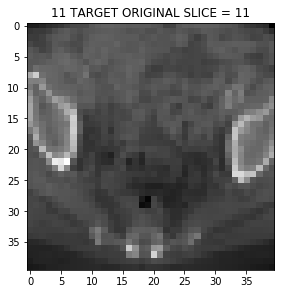

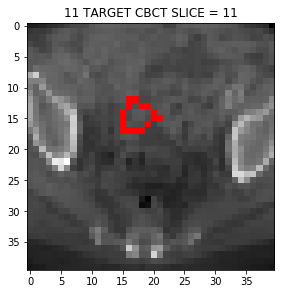

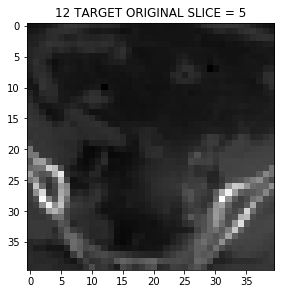

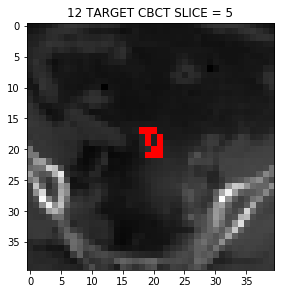

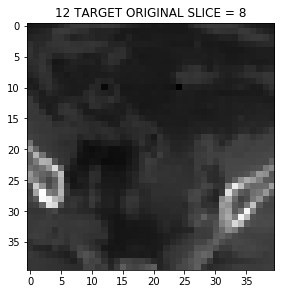

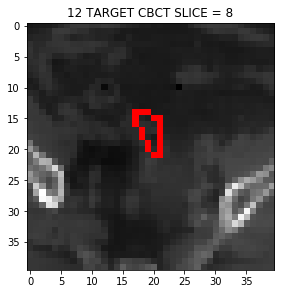

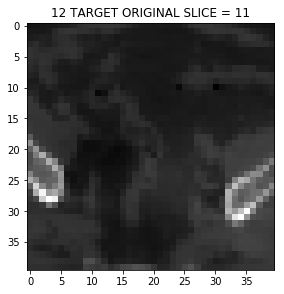

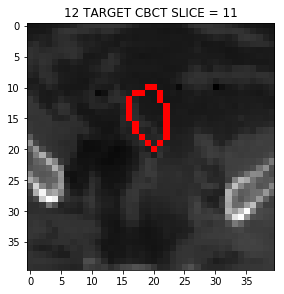

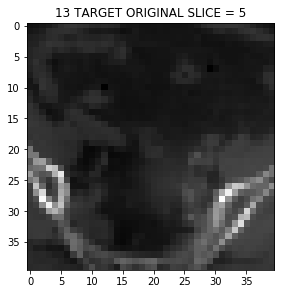

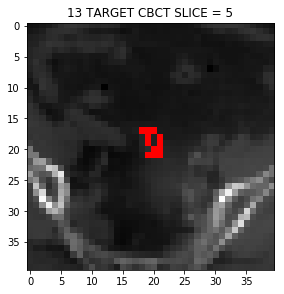

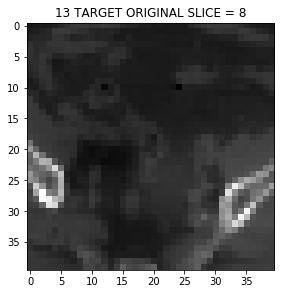

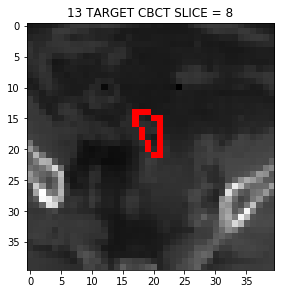

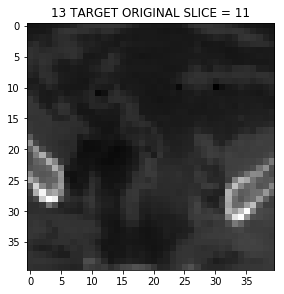

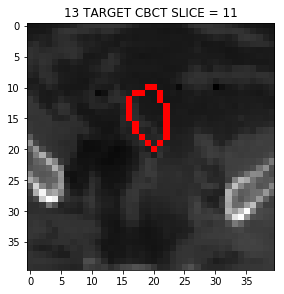

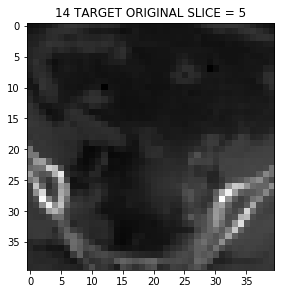

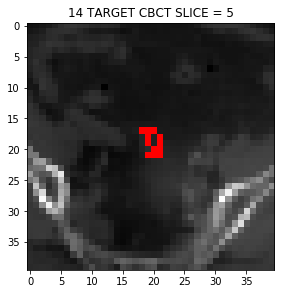

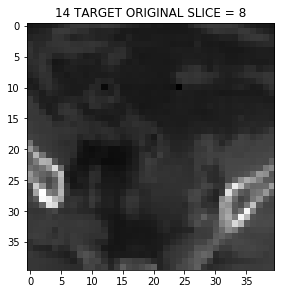

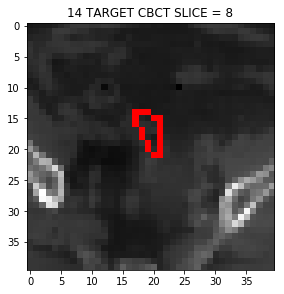

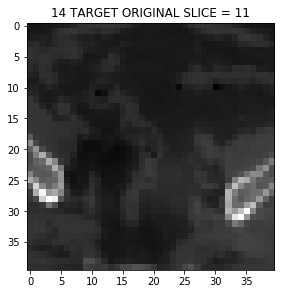

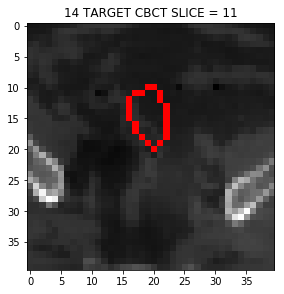

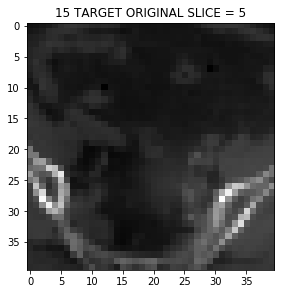

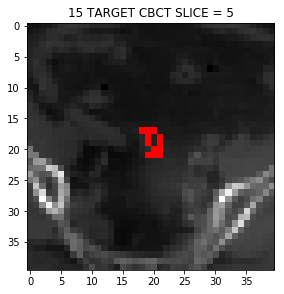

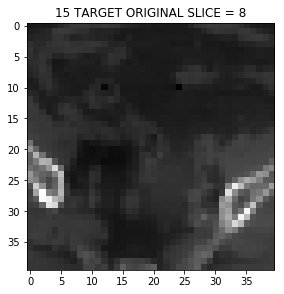

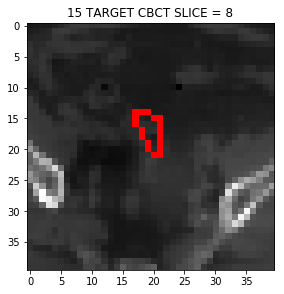

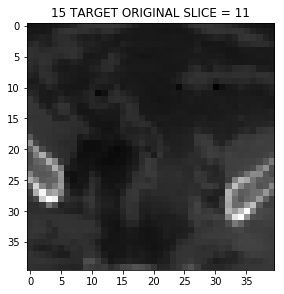

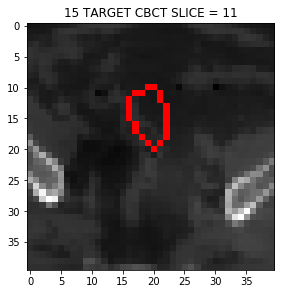

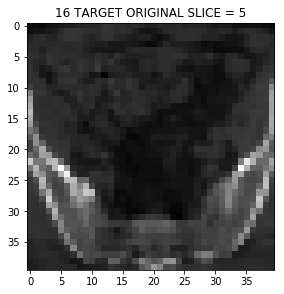

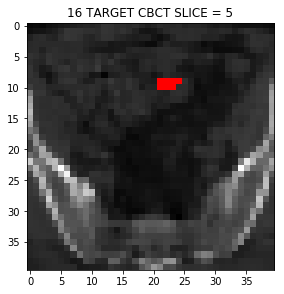

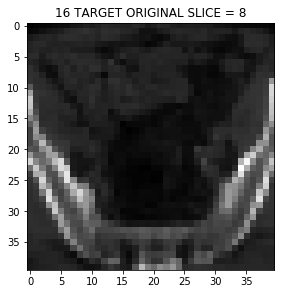

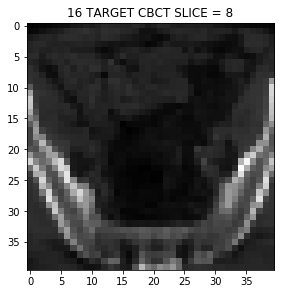

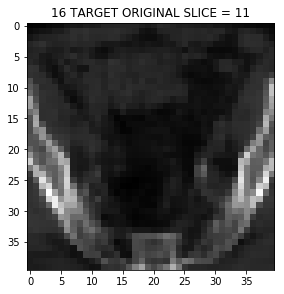

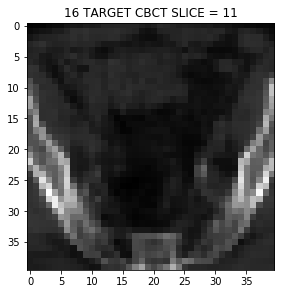

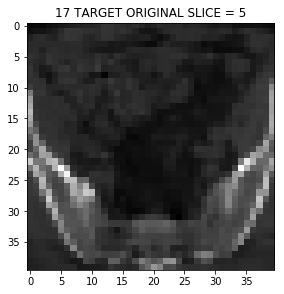

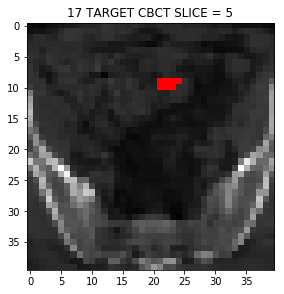

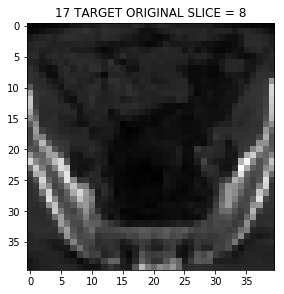

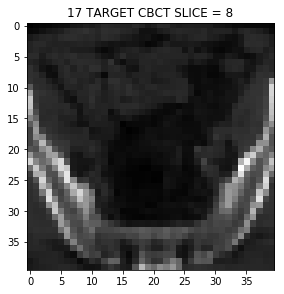

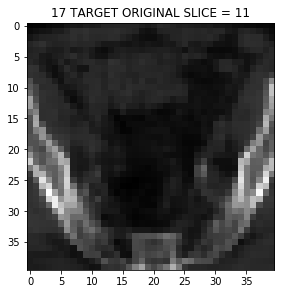

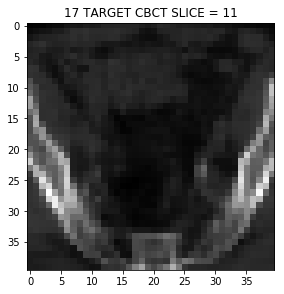

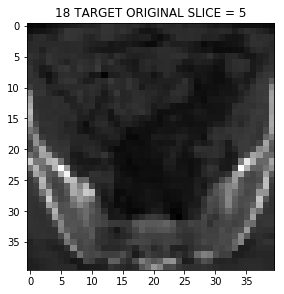

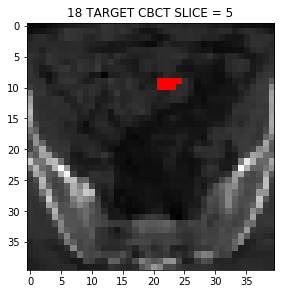

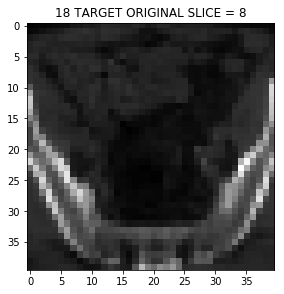

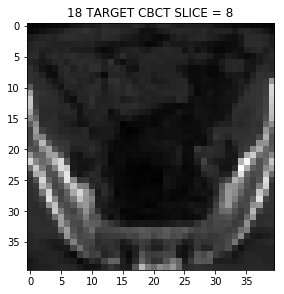

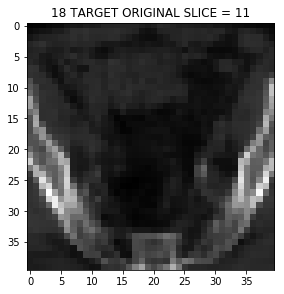

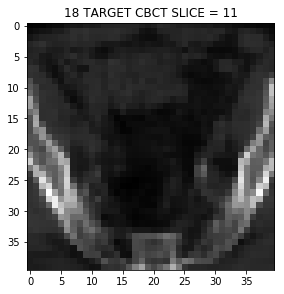

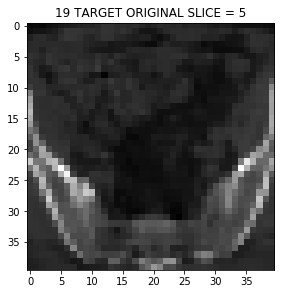

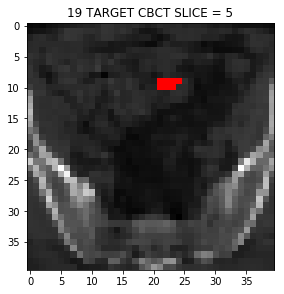

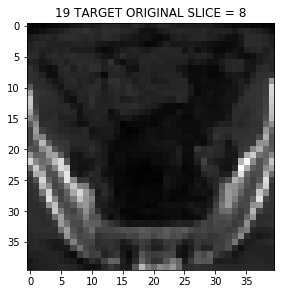

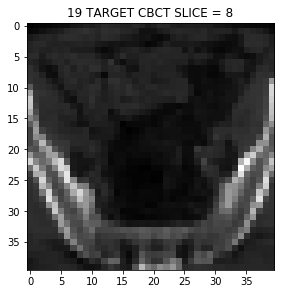

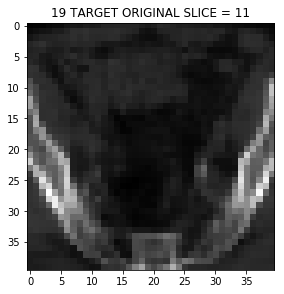

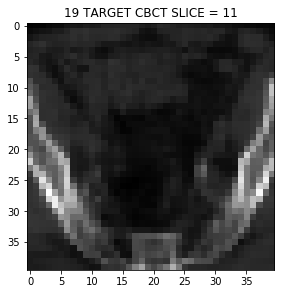

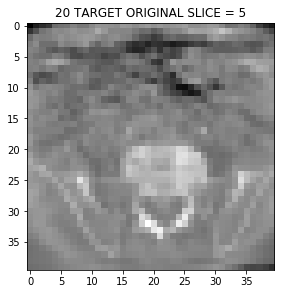

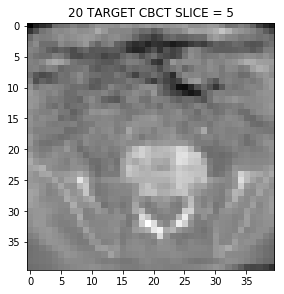

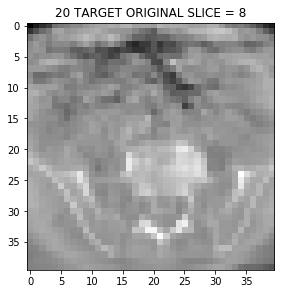

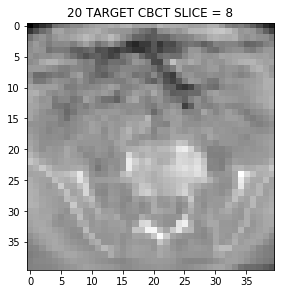

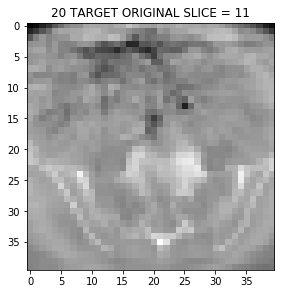

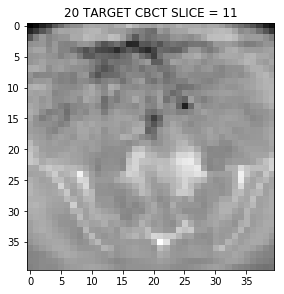

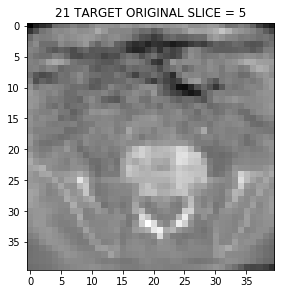

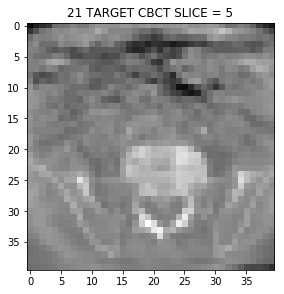

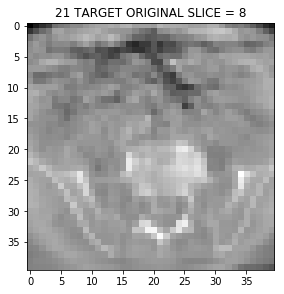

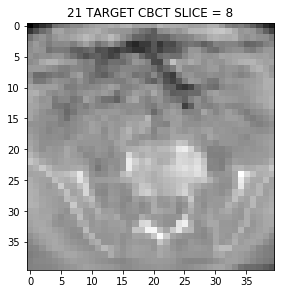

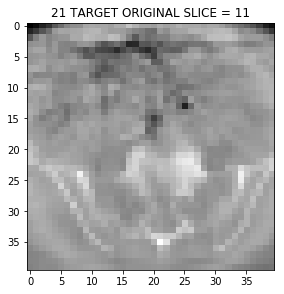

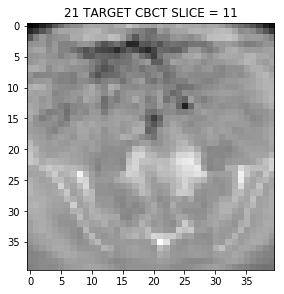

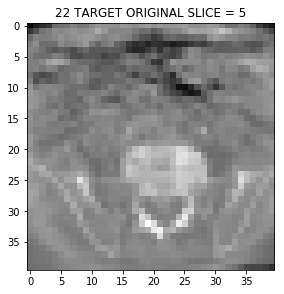

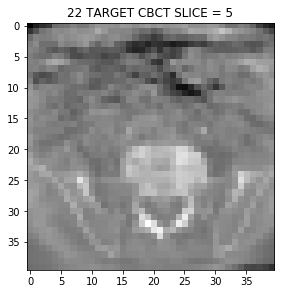

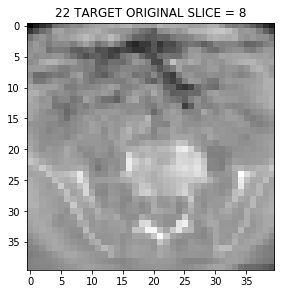

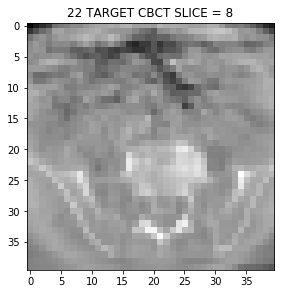

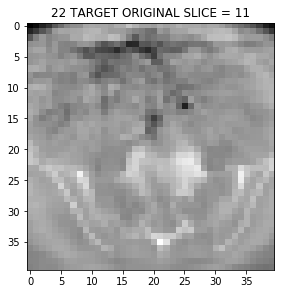

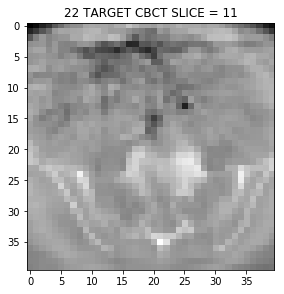

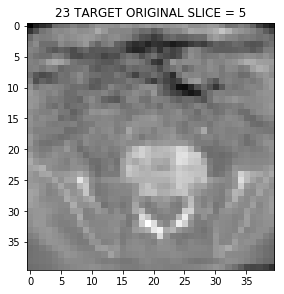

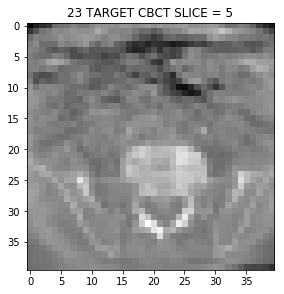

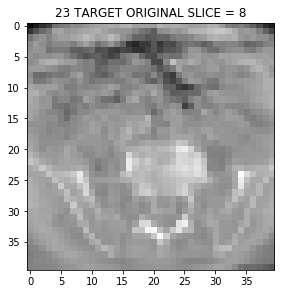

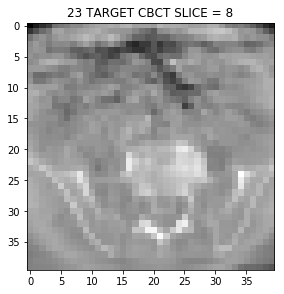

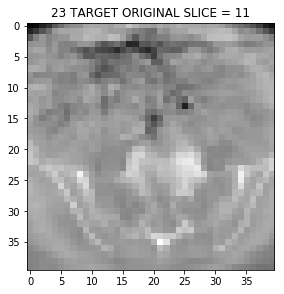

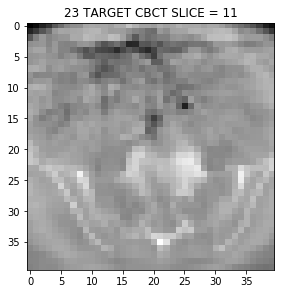

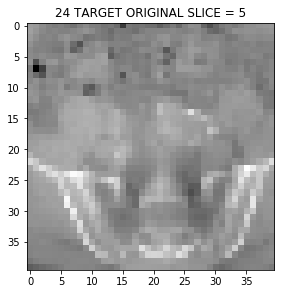

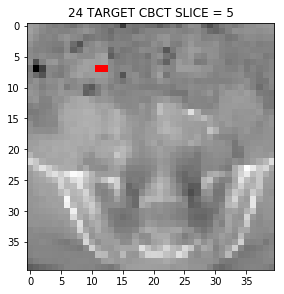

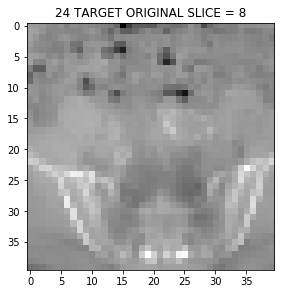

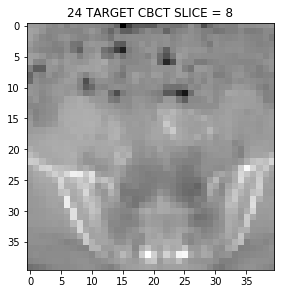

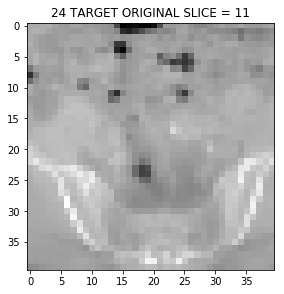

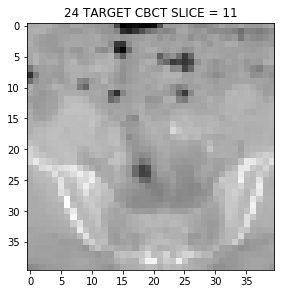

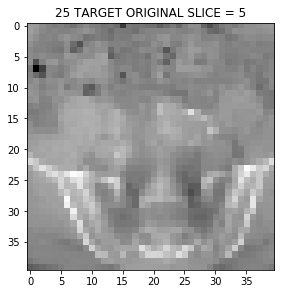

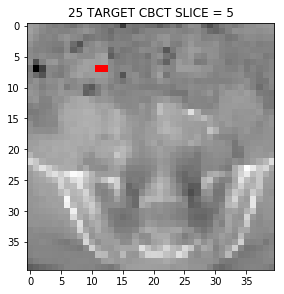

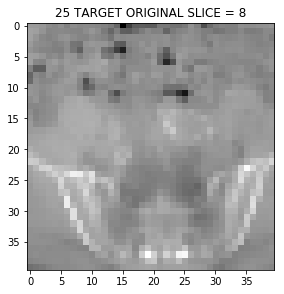

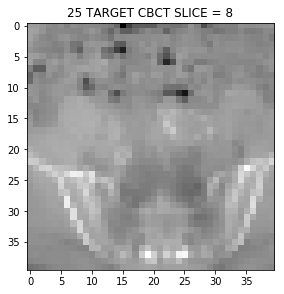

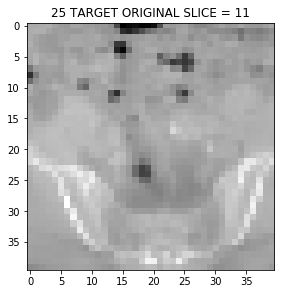

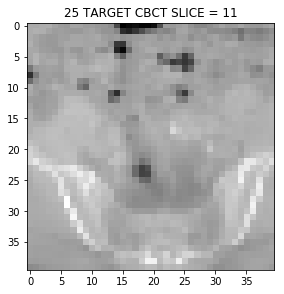

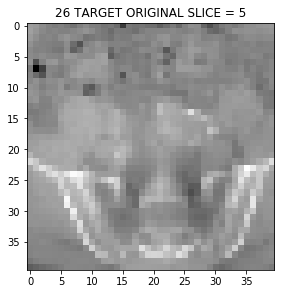

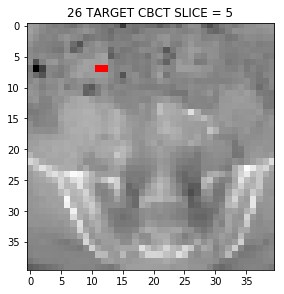

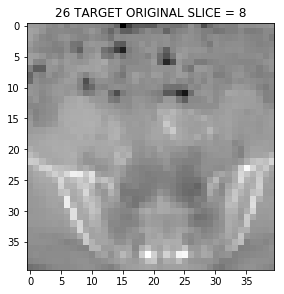

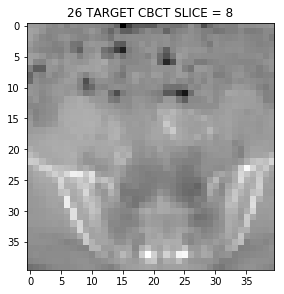

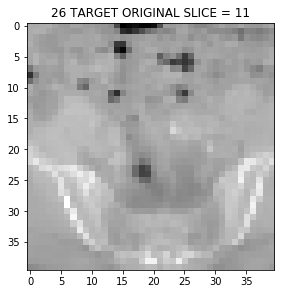

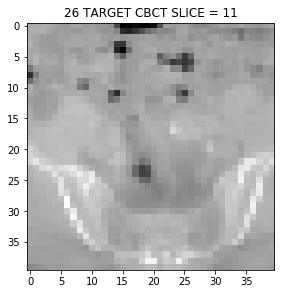

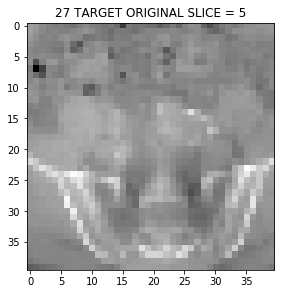

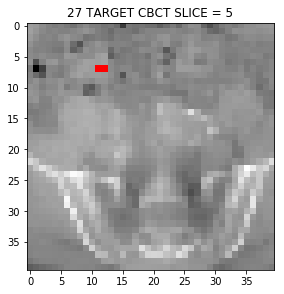

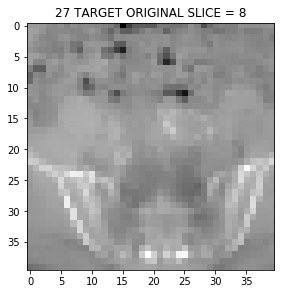

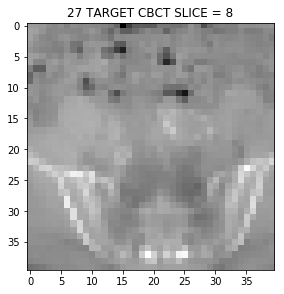

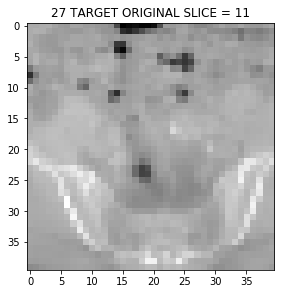

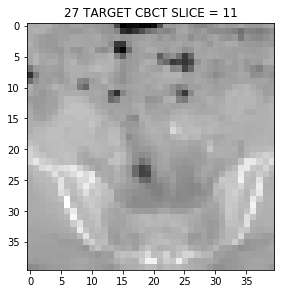

In [10]:
for d in range(len(total_dice_target)):
    
    #Compute distance
    h_dist = 0
    h_dist = Hausdorff_dist(total_pred_masks_target[d],total_original_masks_target[d])
    
    for s in range(len(list_slices)):
        
        # Save np images as .png
        imsave("./closest_pred_mask_target.png".format(), total_pred_masks_target[d][organ_num,:,:,s])
        imsave("./closest_pred_image_target.png".format(), total_original_images_target[d][organ_num,:,:,s,0])
        imsave("./closest_original_mask_target.png".format(), total_original_masks_target[d][organ_num,:,:,s])

        image_original = cv2.imread("closest_pred_image_target.png")

        # Prepare contours ORIGINAL MASK
        mask_original = cv2.imread("closest_original_mask_target.png")
        gray_image_original_mask = cv2.cvtColor(mask_original, cv2.COLOR_BGR2GRAY)

        # Apply cv2.threshold() to get a binary image
        ret, thresh = cv2.threshold(gray_image_original_mask, 50, 255, cv2.THRESH_BINARY)

        # Find contours:
        im, contours_original, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


        # Prepare contours PREDICTED MASK
        mask_pred = cv2.imread("closest_pred_mask_target.png")
        gray_image_pred_mask = cv2.cvtColor(mask_pred, cv2.COLOR_BGR2GRAY)

        # Apply cv2.threshold() to get a binary image
        ret, thresh = cv2.threshold(gray_image_pred_mask, 50, 255, cv2.THRESH_BINARY)

        # Find contours:
        im, contours_pred, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        # Show image:
        plt.figure(figsize=(20,10), frameon=False)
        plt.subplot(2,2,2)
        plt.title(str(d)+' TARGET ORIGINAL SLICE = '+str(list_slices[s]))
        plt.imshow(image_original)
        plt.savefig('./all/target/Original_TARGET_'+str(d)+'_'+str(total_dice_target[d])+'_'+str(h_dist)+'_'+str(list_slices[s])+'.eps', bbox_inches='tight')

        # Draw contours:
        cv2.drawContours(image_original, contours_pred, 0, (255, 0, 0), 1)
        cv2.drawContours(image_original, contours_original, 0, (0, 255, 0), 1)

        # Show image:
        plt.figure(figsize=(20,10), frameon=False)
        plt.subplot(2,2,3)
        plt.title(str(d)+' TARGET CBCT SLICE = '+str(list_slices[s]))
        plt.imshow(image_original)

        # Save the figure
        plt.savefig('./all/target/CBCT_TARGET_'+str(d)+'_'+str(total_dice_target[d])+'_'+str(h_dist)+'_'+str(list_slices[s])+'.eps', bbox_inches='tight')


## UDA

0.633154857239118
[0.7666060054595086, 0.4347826086956522, 0.8318274555523172, 0.783662866214461, 0.7347294938917975, 0.6419264390565728, 0.630784123910939, 0.40923854204258386, 0.5587964384402824, 0.28413853959849994, 0.8562615669339914, 0.7431693989071039, 0.7941807774862867, 0.8905616676317313, 0.7557096247960848, 0.7624113475177305, 0.8081368469717983, 0.7219288982752552, 0.3462028001697073, 0.7749999999999999, 0.7112970711297071, 0.6846205208101491, 0.4693799923925447, 0.8538743136058572, 0.6033382425135003, 0.6267087276550999, 0.8189734658334187, 0.6963979416809606]


/export/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
/export/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app
/export/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  app.launch_new_instance()
/export/share/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may cons

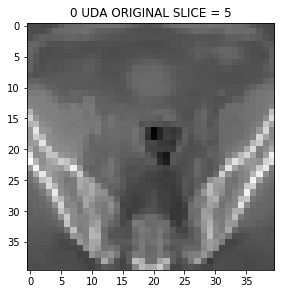

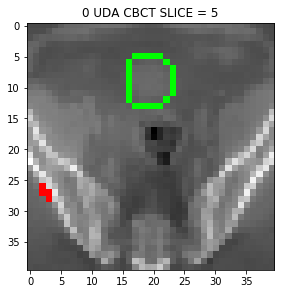

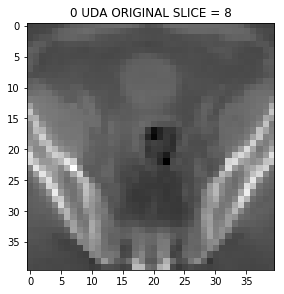

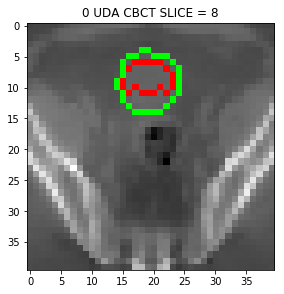

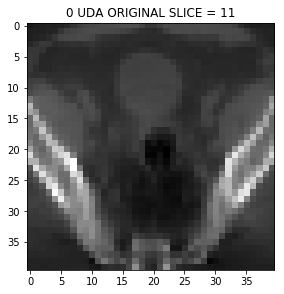

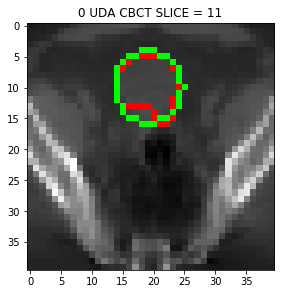

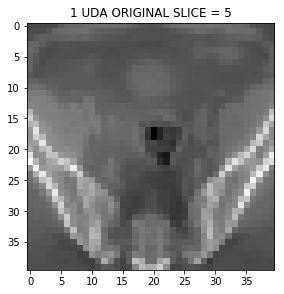

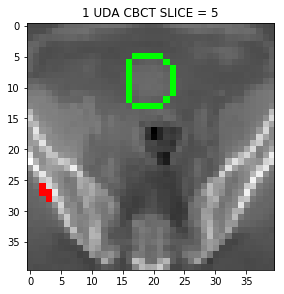

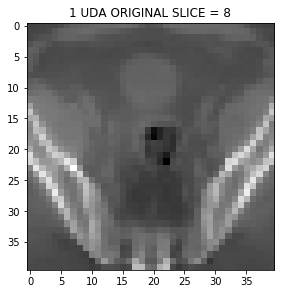

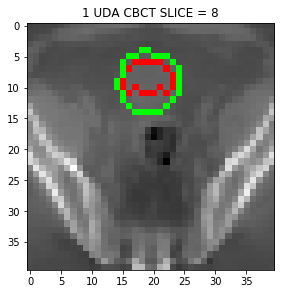

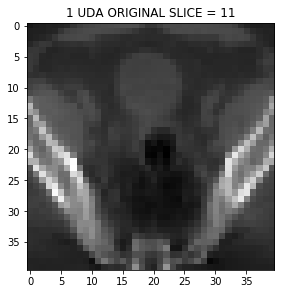

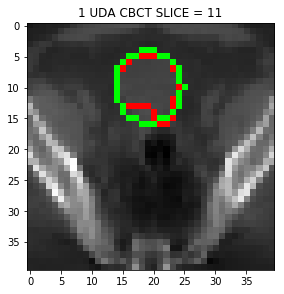

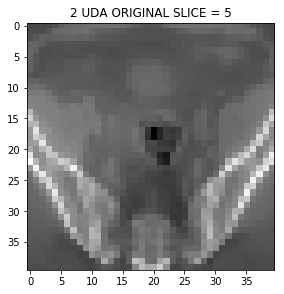

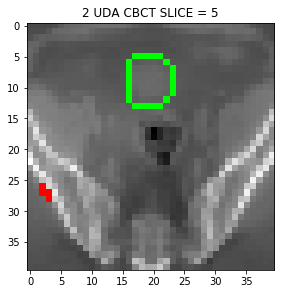

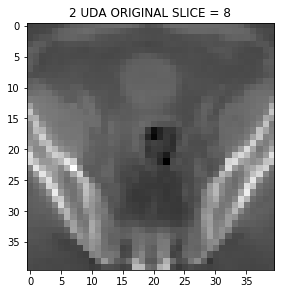

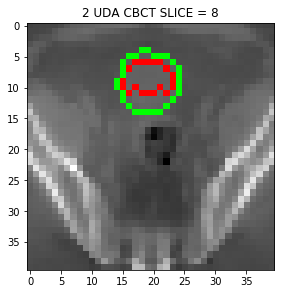

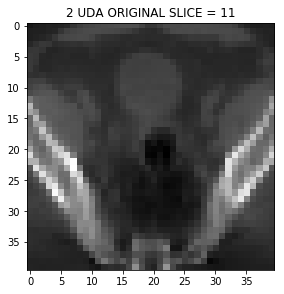

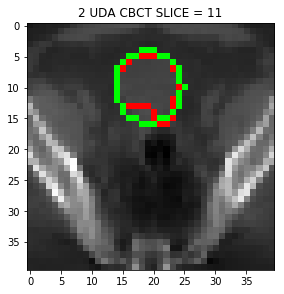

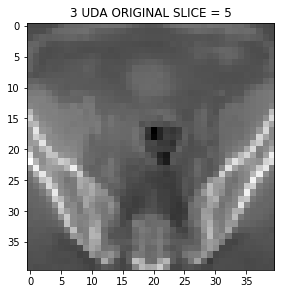

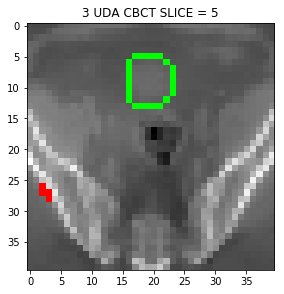

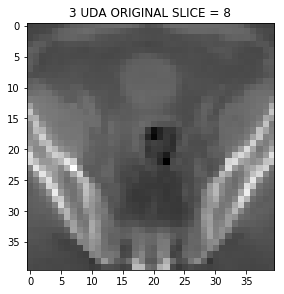

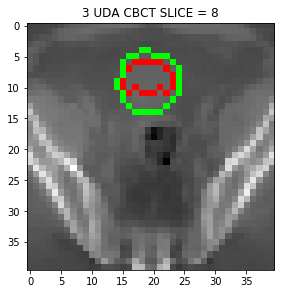

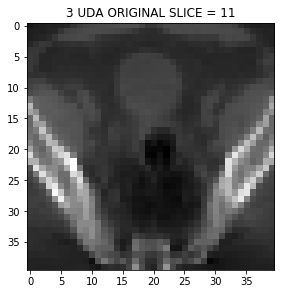

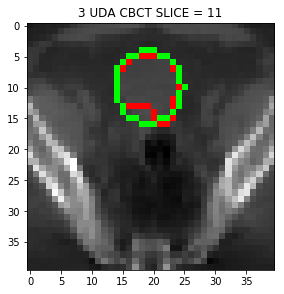

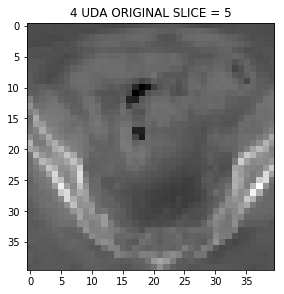

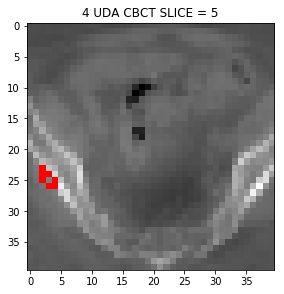

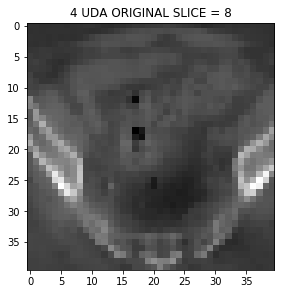

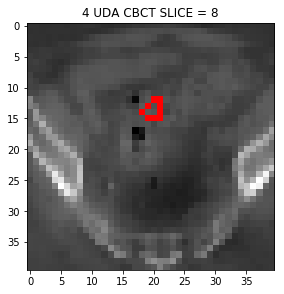

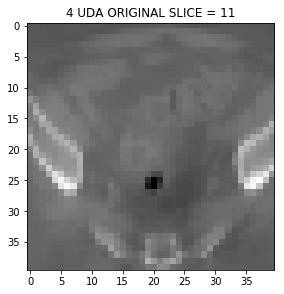

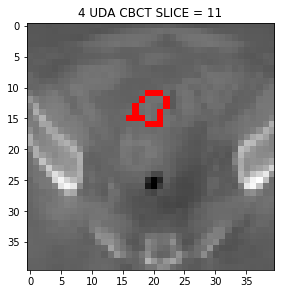

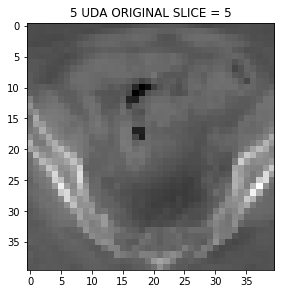

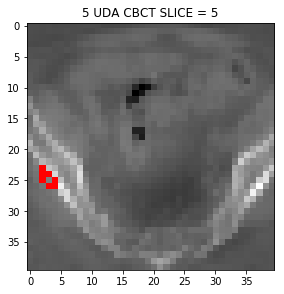

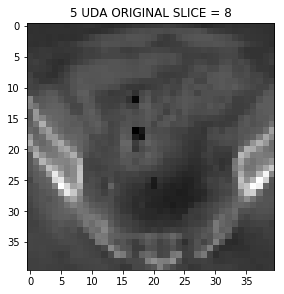

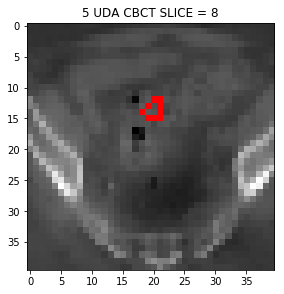

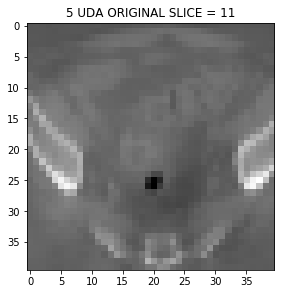

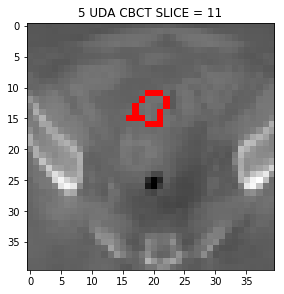

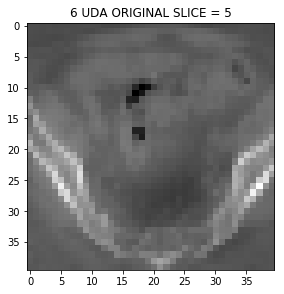

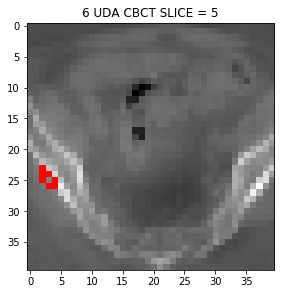

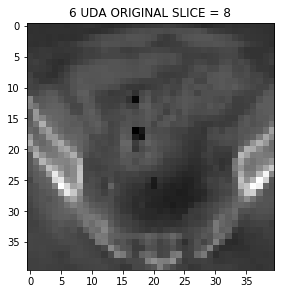

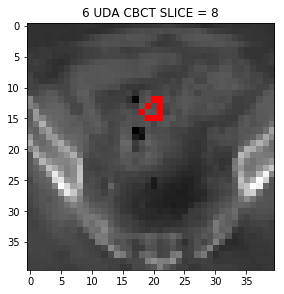

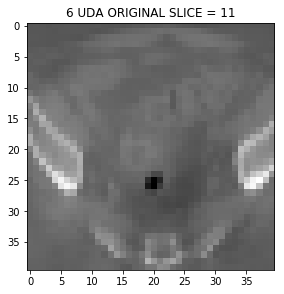

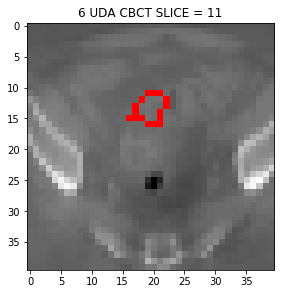

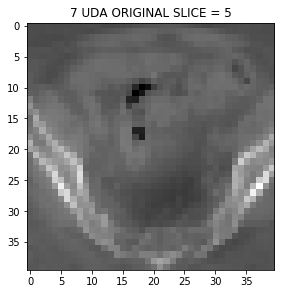

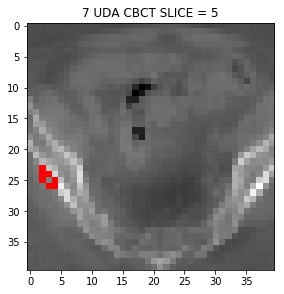

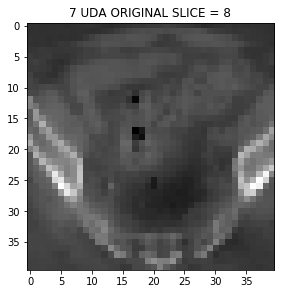

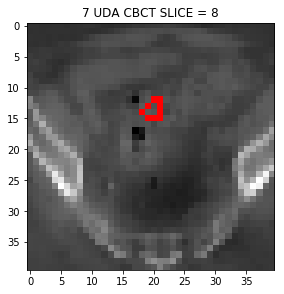

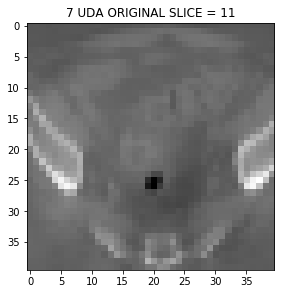

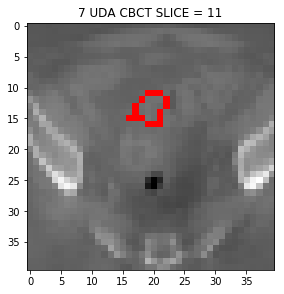

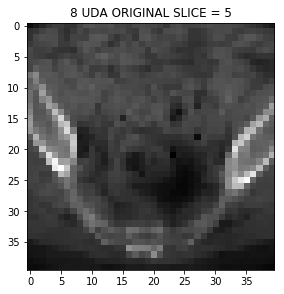

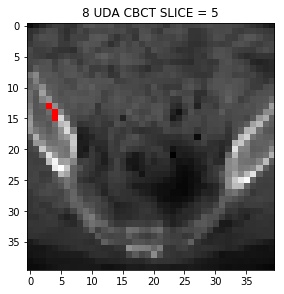

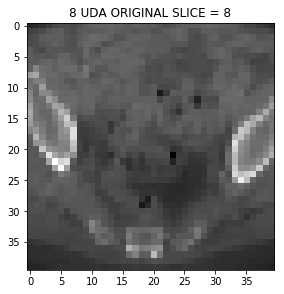

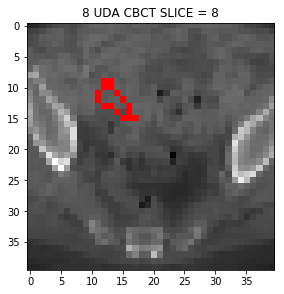

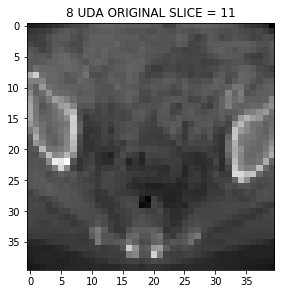

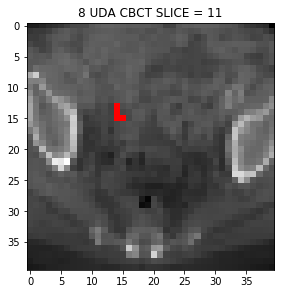

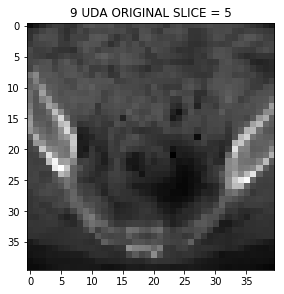

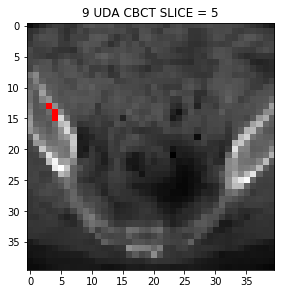

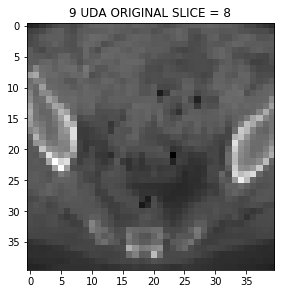

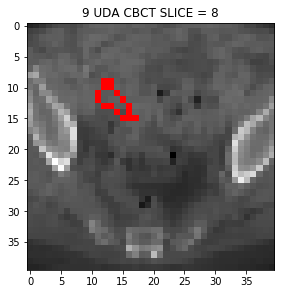

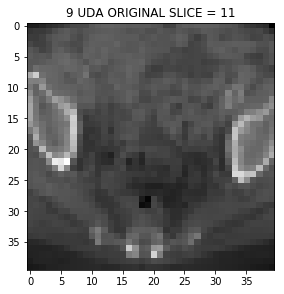

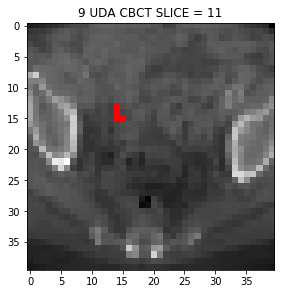

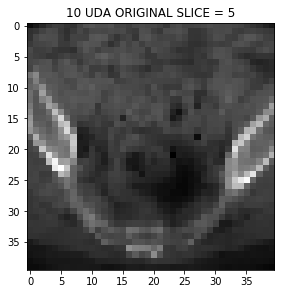

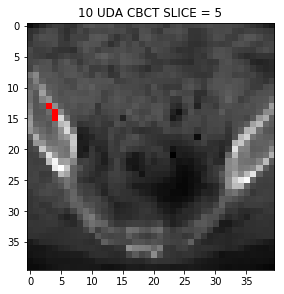

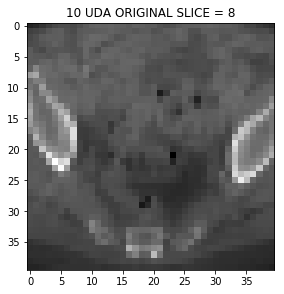

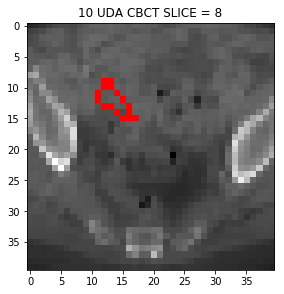

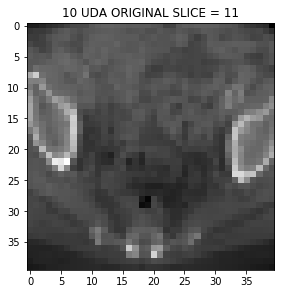

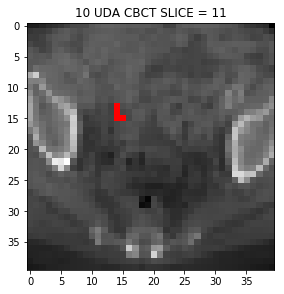

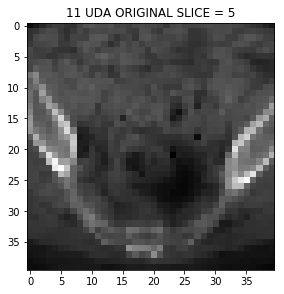

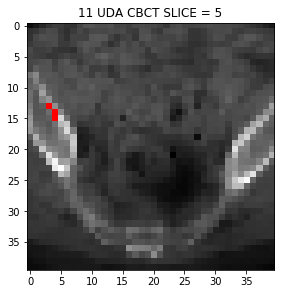

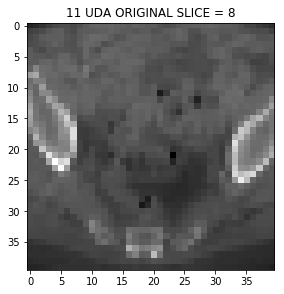

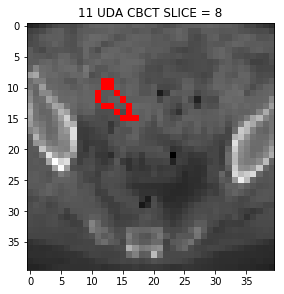

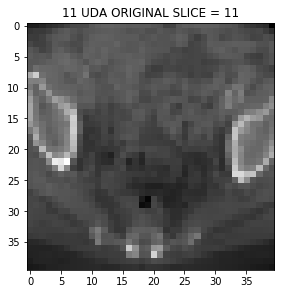

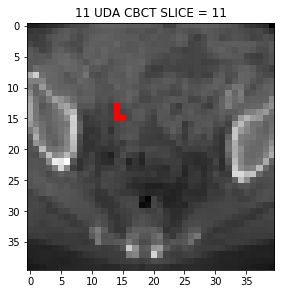

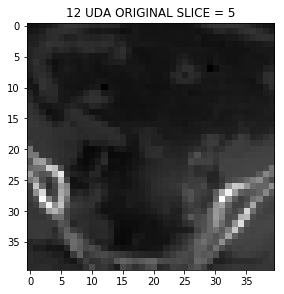

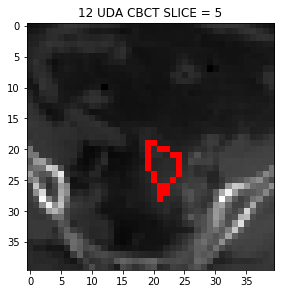

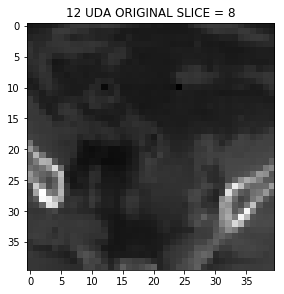

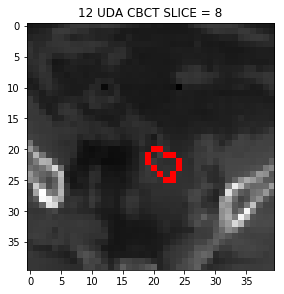

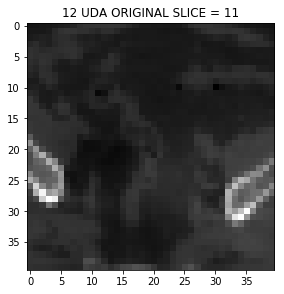

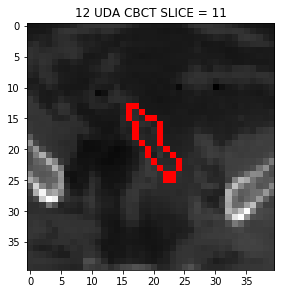

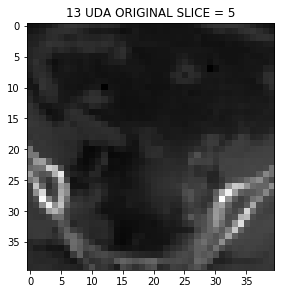

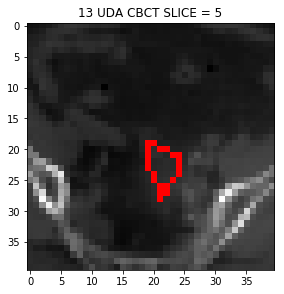

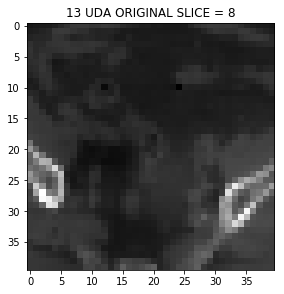

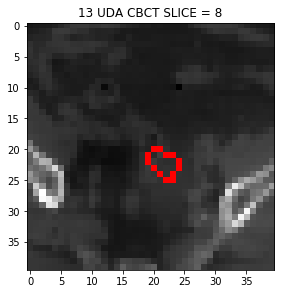

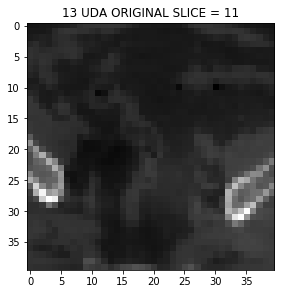

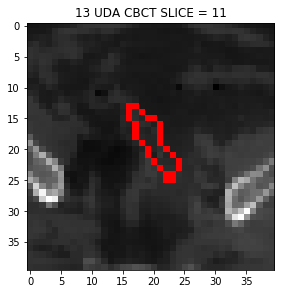

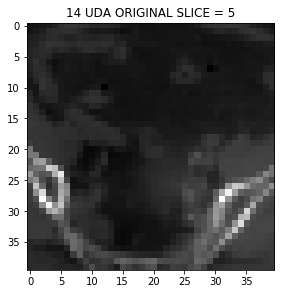

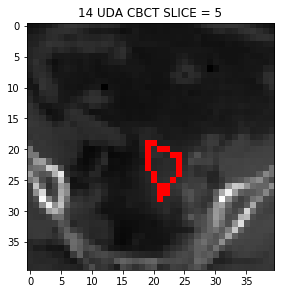

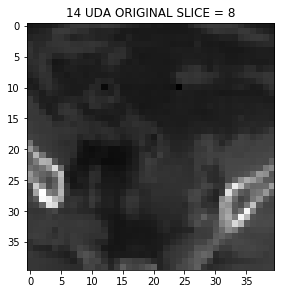

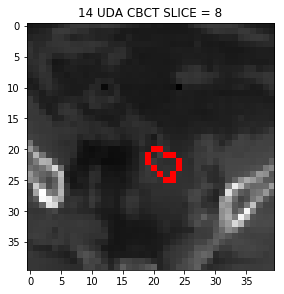

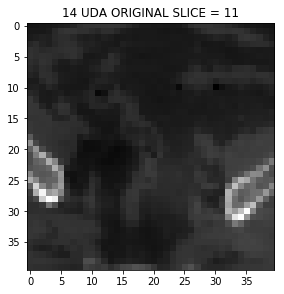

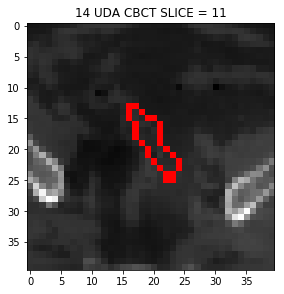

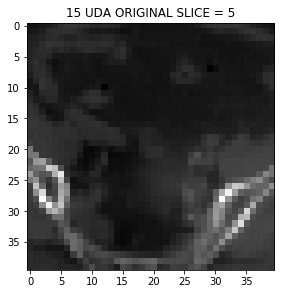

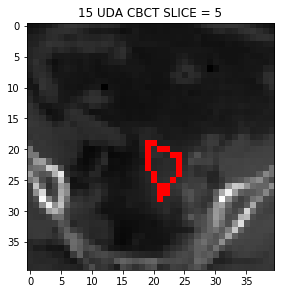

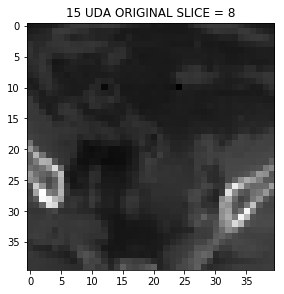

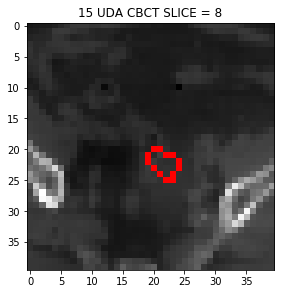

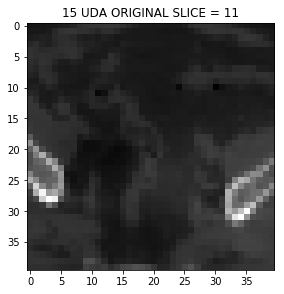

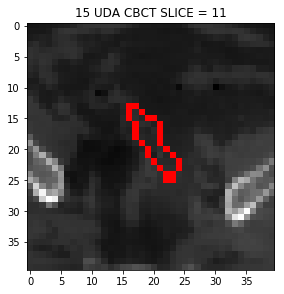

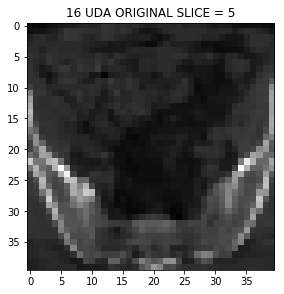

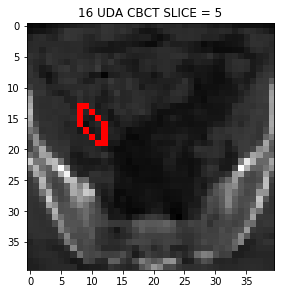

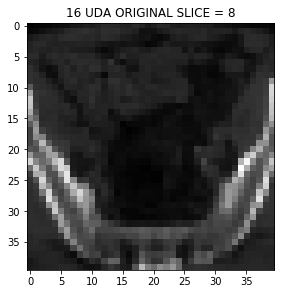

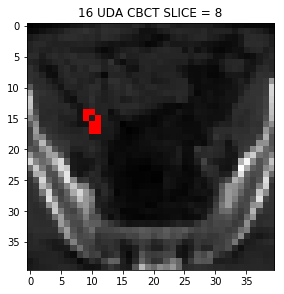

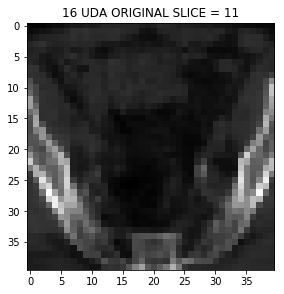

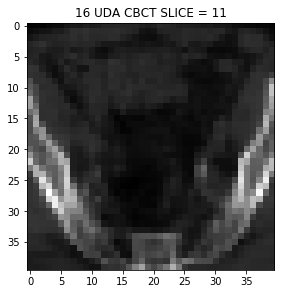

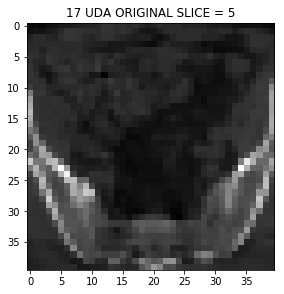

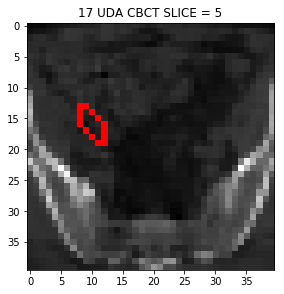

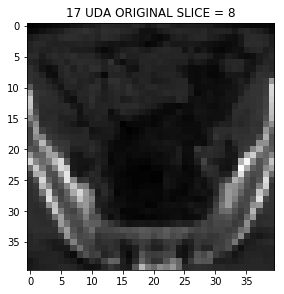

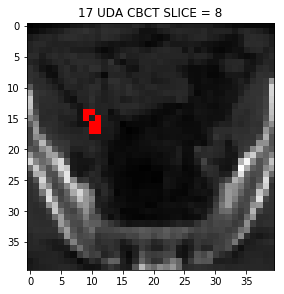

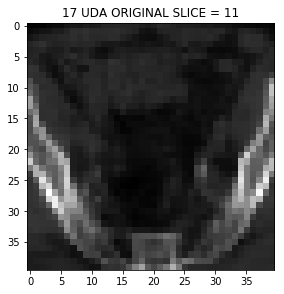

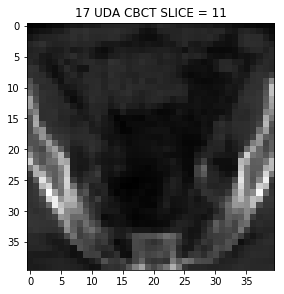

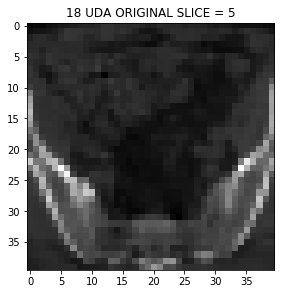

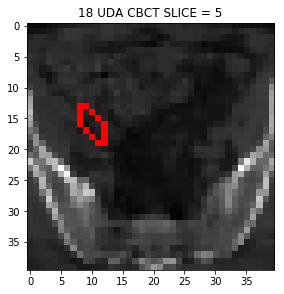

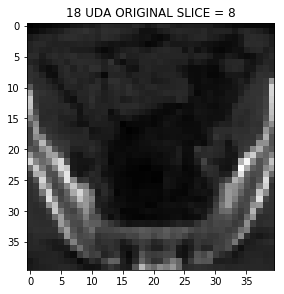

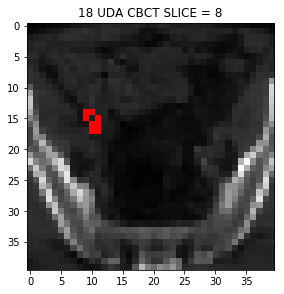

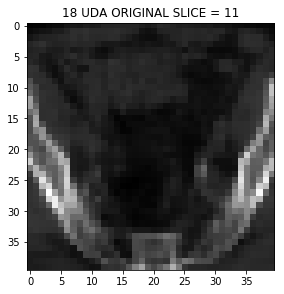

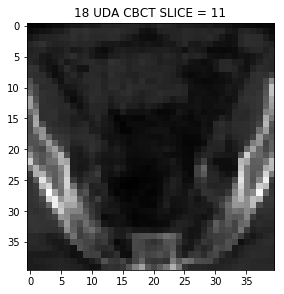

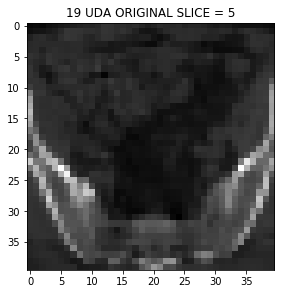

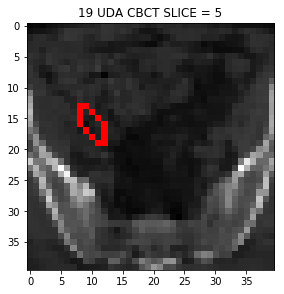

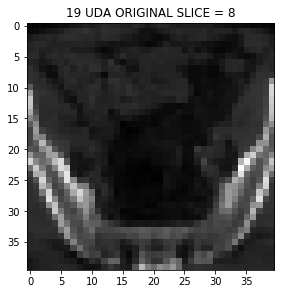

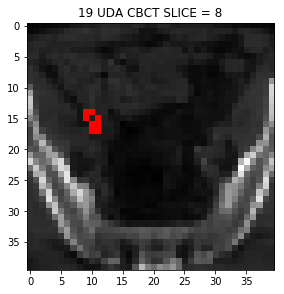

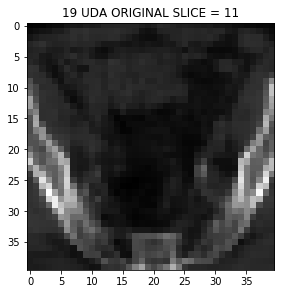

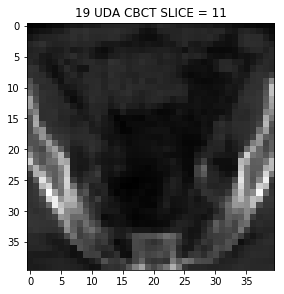

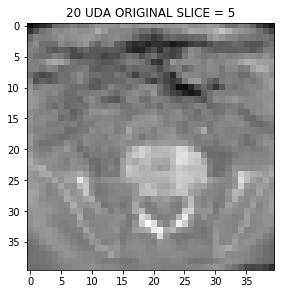

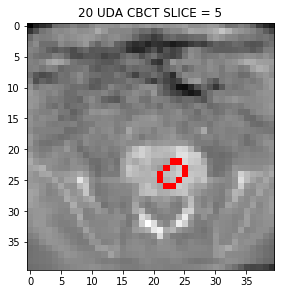

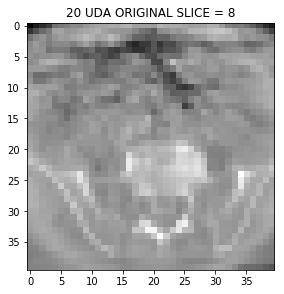

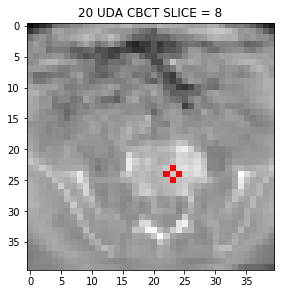

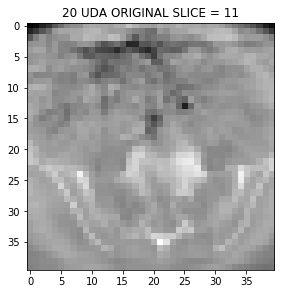

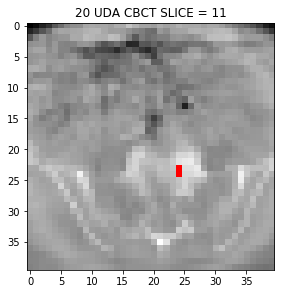

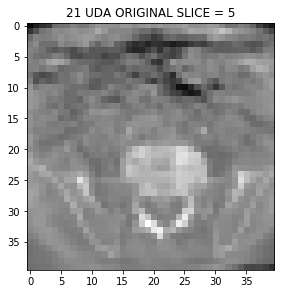

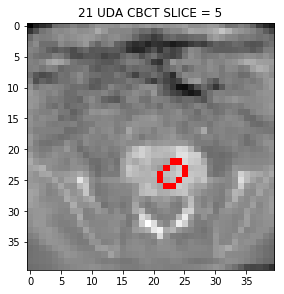

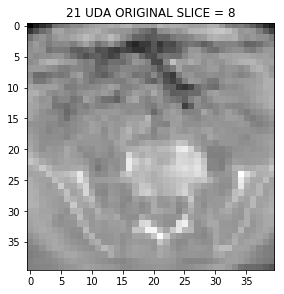

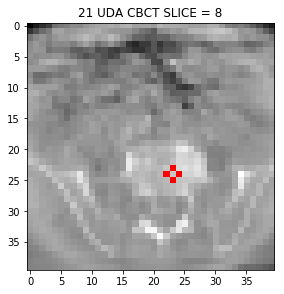

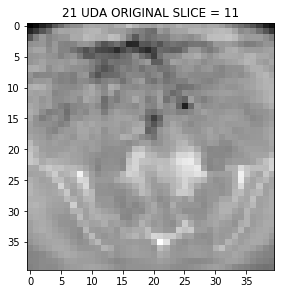

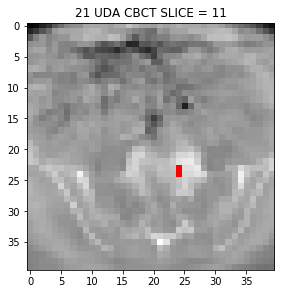

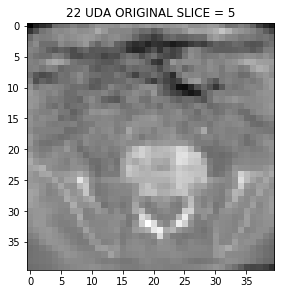

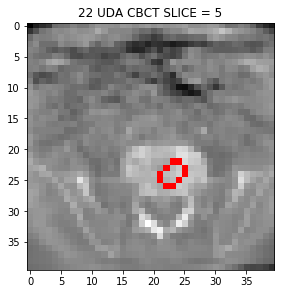

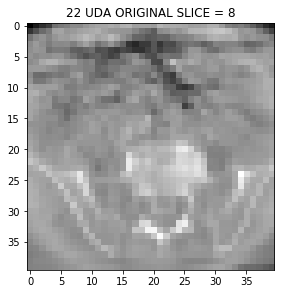

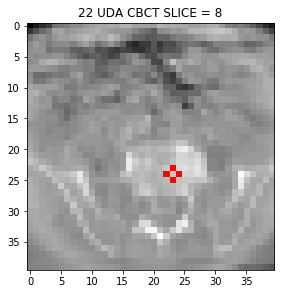

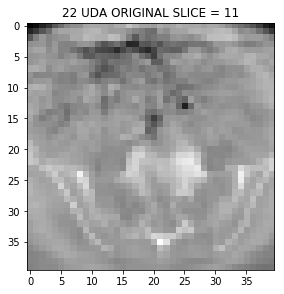

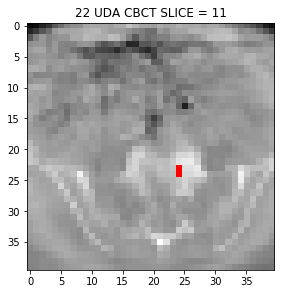

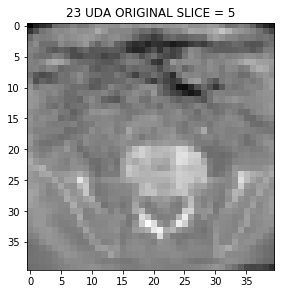

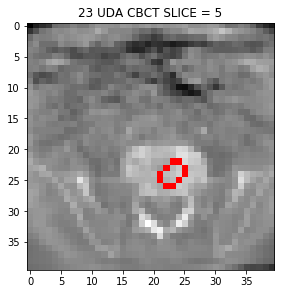

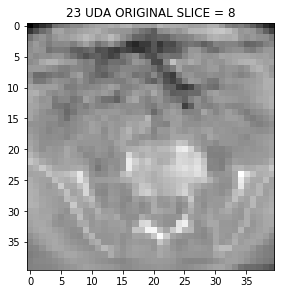

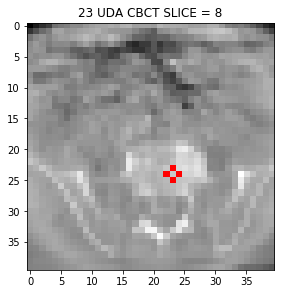

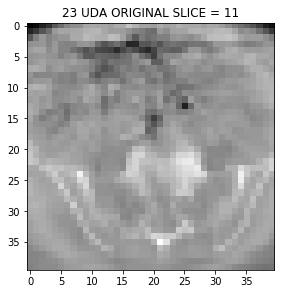

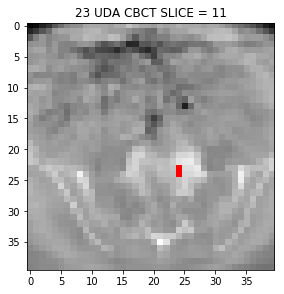

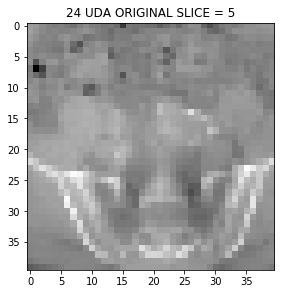

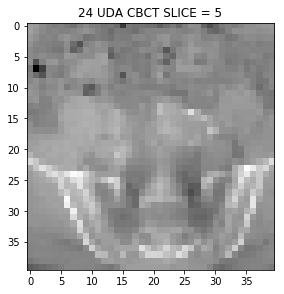

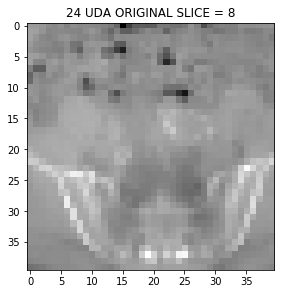

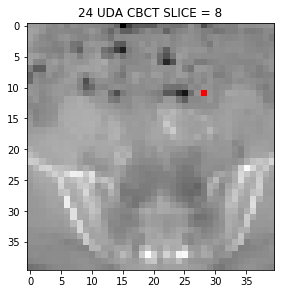

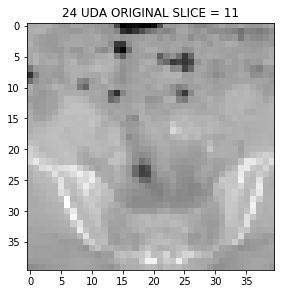

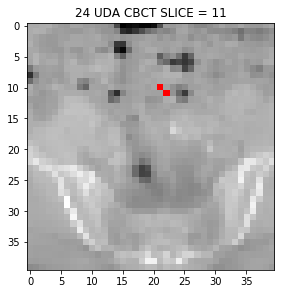

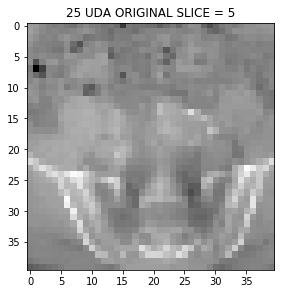

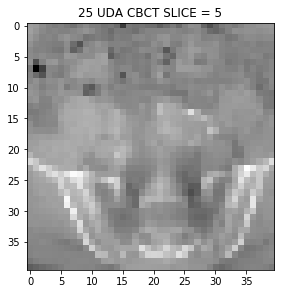

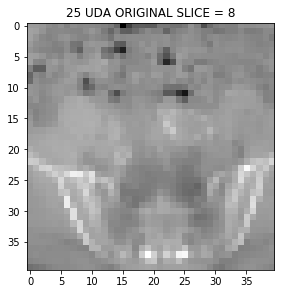

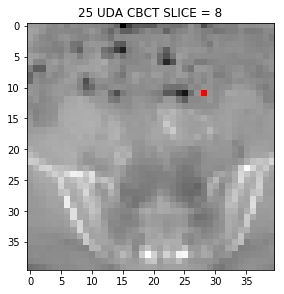

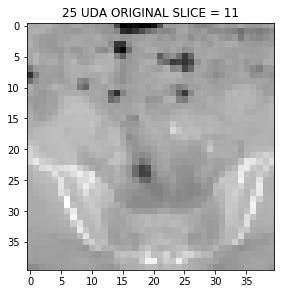

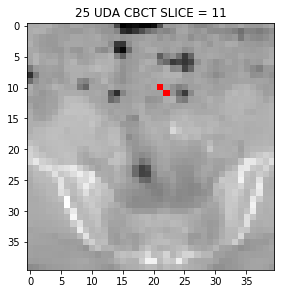

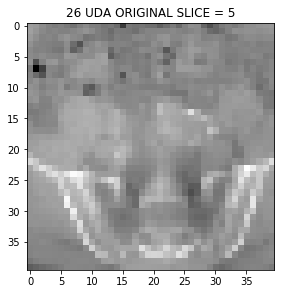

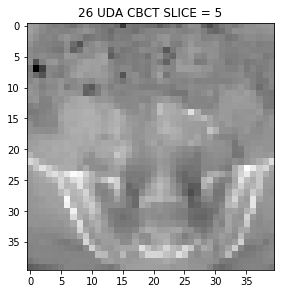

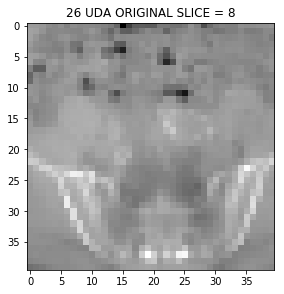

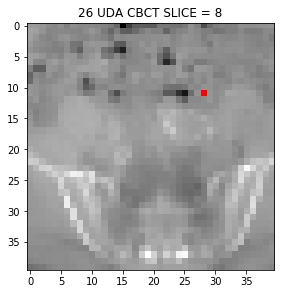

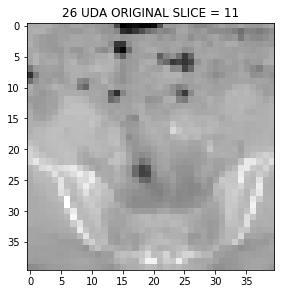

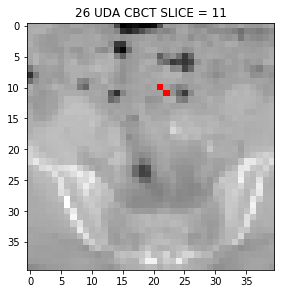

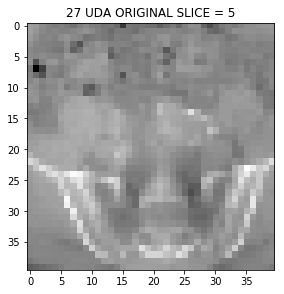

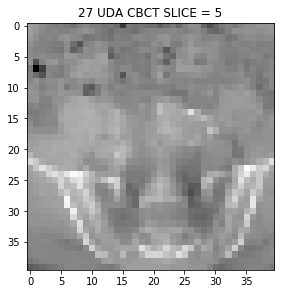

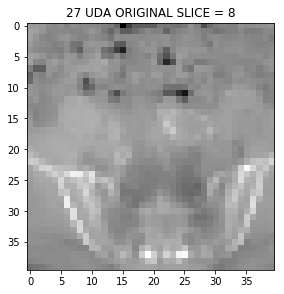

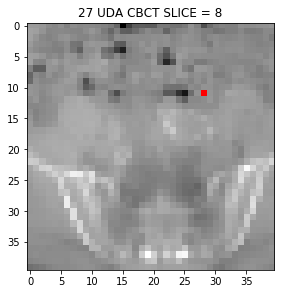

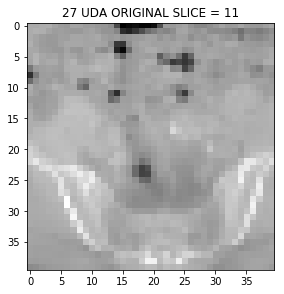

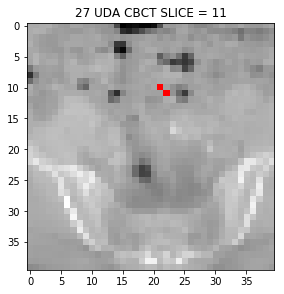

In [10]:
for d in range(len(total_dice_dann)):
    
    #Compute distance
    h_dist = 0
    h_dist = Hausdorff_dist(total_pred_masks_dann[d],total_original_masks_dann[d])
    
    for s in range(len(list_slices)):
        
        # Save np images as .png
        imsave("./closest_pred_mask_dann.png".format(), total_pred_masks_dann[d][organ_num,:,:,s])
        imsave("./closest_pred_image_dann.png".format(), total_original_images_dann[d][organ_num,:,:,s,0])
        imsave("./closest_original_mask_dann.png".format(), total_original_masks_dann[d][organ_num,:,:,s])

        image_original = cv2.imread("closest_pred_image_dann.png")

        # Prepare contours ORIGINAL MASK
        mask_original = cv2.imread("closest_original_mask_dann.png")
        gray_image_original_mask = cv2.cvtColor(mask_original, cv2.COLOR_BGR2GRAY)

        # Apply cv2.threshold() to get a binary image
        ret, thresh = cv2.threshold(gray_image_original_mask, 50, 255, cv2.THRESH_BINARY)

        # Find contours:
        im, contours_original, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


        # Prepare contours PREDICTED MASK
        mask_pred = cv2.imread("closest_pred_mask_dann.png")
        gray_image_pred_mask = cv2.cvtColor(mask_pred, cv2.COLOR_BGR2GRAY)

        # Apply cv2.threshold() to get a binary image
        ret, thresh = cv2.threshold(gray_image_pred_mask, 50, 255, cv2.THRESH_BINARY)

        # Find contours:
        im, contours_pred, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        # Show image:
        plt.figure(figsize=(20,10), frameon=False)
        plt.subplot(2,2,2)
        plt.title(str(d)+' UDA ORIGINAL SLICE = '+str(list_slices[s]))
        plt.imshow(image_original)
        plt.savefig('./all/uda/Original_UDA_'+str(d)+'_'+str(total_dice_dann[d])+'_'+str(h_dist)+'_'+str(list_slices[s])+'.eps', bbox_inches='tight')

        # Draw contours:
        cv2.drawContours(image_original, contours_pred, 0, (255, 0, 0), 1)
        cv2.drawContours(image_original, contours_original, 0, (0, 255, 0), 1)

        # Show image:
        plt.figure(figsize=(20,10), frameon=False)
        plt.subplot(2,2,3)
        plt.title(str(d)+' UDA CBCT SLICE = '+str(list_slices[s]))
        plt.imshow(image_original)

        # Save the figure
        plt.savefig('./all/uda/CBCT_UDA_'+str(d)+'_'+str(total_dice_dann[d])+'_'+str(h_dist)+'_'+str(list_slices[s])+'.eps', bbox_inches='tight')
